**📊 Objectif du Projet 📈**

Notre mission colossale : mettre en œuvre la classification non supervisée pour segmenter les séries temporelles reflétant la consommation électrique dans 100 foyers. L'automatisation de la détection des perturbations, révélatrices de changements collectifs dans les habitudes de consommation sur une période de 91 jours, avec des intervalles de 30 minutes, constitue le cœur palpitant de notre démarche. Précision et profondeur, incarnées par notre analyse, sont les étoiles qui guident notre exploration. Plongeons dans cette aventure avec un engagement inflexible. 🌐⚙️

**Table des matières 📑**
1. Importation des librairies/packages nécessaires 📦
2. Analyse descriptive des données 📊
3. Réduction de la dimension 📉
   - ACP - Analyse de Composantes Principales 📈
   - Caractéristiques des séries temporelles 📊
   - Transformée de Fourier 🔄
4. Clustering 🧩
   - CAH - Classification Hiérarchique 🌳
   - K-means 🎯
   - Spectral Clustering 🌈
   - SOM 🗺️
5. Analyse sur clusters 📊
6. Ruptures - Segmentation 🚀es - Segmentation

## Importation des librairies / packages nécessaires

In [1]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import requests
import random
import calendar
import time

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data Preprocessing
from sklearn import preprocessing

#### Download and Read the data

In [2]:
def read_data_from_url(url):
    """
    Read data from a given URL and return a DataFrame.

    Parameters:
    - url (str): The URL of the data file.

    Returns:
    - pd.DataFrame: The DataFrame containing the data.
    """
    response = requests.get(url)
    return pd.read_csv(StringIO(response.text), header=None, delimiter="\s+")


def rename_columns(df, new_column_names):
    """
    Rename columns of a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be modified.
    - new_column_names (dict): A dictionary mapping old column names to new column names.
    """
    df.rename(columns=new_column_names, inplace=True)


def melt_dataframe(df, name):
    """
    Reshape a DataFrame by melting it and return the melted DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be melted.
    - name (str): The name for the melted values.

    Returns:
    - pd.DataFrame: The melted DataFrame.
    """
    melted_df = pd.melt(df, var_name="COLUMN", value_name=name)
    melted_df.drop(columns=["COLUMN"], inplace=True)
    melted_df.reset_index(drop=True, inplace=True)
    return melted_df


def process_appart_data(url_x, url_appart):
    """
    Process apartment data from two URLs and return a formatted DataFrame.

    Parameters:
    - url_x (str): The URL of the first data file (df_x).
    - url_appart (str): The URL of the second data file (df_appart).

    Returns:
    - pd.DataFrame: The processed DataFrame containing apartment data.
    """
    df_x = read_data_from_url(url_x)
    df_appart = read_data_from_url(url_appart)

    column_rename_mapping = {0: "APPART"}
    rename_columns(df_appart, column_rename_mapping)

    merged_df = pd.concat([df_appart, df_x], axis=1)

    appartements_dataframes = {}

    for appart_id in range(1, 101):  # The is 100 appartements in total
        filtered_appartments = merged_df.query("APPART == @appart_id").transpose()[1:]

        column_mapping = {
            old_column: f"JOUR_{old_column}"
            for old_column in filtered_appartments.columns
        }
        filtered_appartments.rename(columns=column_mapping, inplace=True)

        appartements_dataframes[f"appt_{appart_id}"] = melt_dataframe(
            filtered_appartments, f"appartement_{appart_id}"
        )

    result_df = pd.concat(appartements_dataframes.values(), axis=1)

    time_column = pd.date_range(start="1/1/2023", periods=len(result_df), freq="30min")
    result_df = pd.concat(
        [pd.DataFrame(time_column, columns=["Time"]), result_df], axis=1
    )

    return result_df


# URLs for the data
url_x = "http://allousame.free.fr/mlds/donnees/X.txt"
url_appart = "http://allousame.free.fr/mlds/donnees/APPART.txt"

# Process data and get the result DataFrame
appartements = process_appart_data(url_x, url_appart)

## Analyse descriptive des données 

In [3]:
appartements.head(3)

,Time,appartement_1,appartement_2,appartement_3,appartement_4,appartement_5,appartement_6,appartement_7,appartement_8,appartement_9,...,appartement_91,appartement_92,appartement_93,appartement_94,appartement_95,appartement_96,appartement_97,appartement_98,appartement_99,appartement_100
0,2023-01-01 00:00:00,-1.786785,-1.696926,0.152293,-0.951338,-1.117863,-0.619164,-1.934051,-1.231540,-0.915803,...,-1.458296,-0.943808,-1.058543,0.094067,-0.551474,-1.476726,-0.147306,-1.459160,-1.636396,-0.587143
1,2023-01-01 00:30:00,-1.759306,-1.589682,-0.001868,-1.038791,-1.209420,-0.809750,-1.509850,-1.642594,-0.966073,...,-1.435501,-1.081751,-1.189145,-0.598292,-0.770247,-1.384780,-0.628073,-1.487654,-1.735798,-0.958683
2,2023-01-01 01:00:00,-1.731826,-1.482438,-0.156029,-1.126245,-1.300976,-1.000337,-1.085648,-2.053648,-1.016343,...,-1.412706,-1.219694,-1.319748,-1.290650,-0.989019,-1.292834,-1.108839,-1.516149,-1.835200,-1.330222


#### Energy Consumption of apartment 1 to 5 over the time

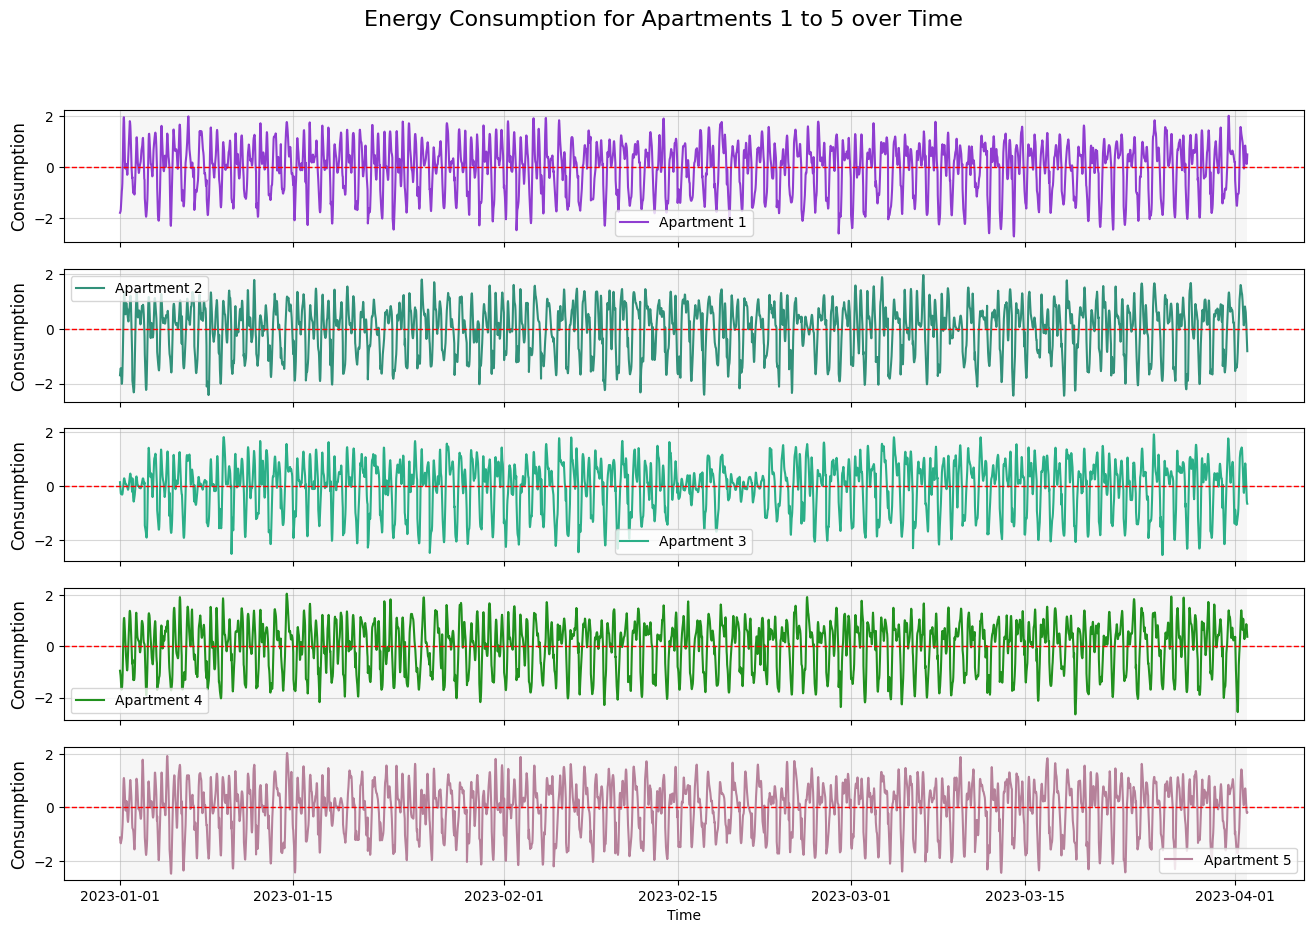

In [4]:
# Function to plot the evolution of energy consumption for multiple apartments
def plot_energy_evolution_subplots(data, apartments_list, title):
    num_apartments = len(apartments_list)
    fig, axes = plt.subplots(
        num_apartments, 1, figsize=(16, 2 * num_apartments), sharex=True
    )

    # Iterate through the list of apartments to plot each one
    for i, apartment in enumerate(apartments_list, start=1):
        color = "#{:06x}".format(
            random.randint(0, 0xFFFFFF)
        )  # Generate a random hex color
        sns.lineplot(
            data=data,
            x="Time",
            y=apartment,
            ax=axes[i - 1],
            label=f"Apartment {i}",
            color=color,
        )

        # Add labels for each subplot
        axes[i - 1].set_ylabel("Consumption", fontsize=12)
        axes[i - 1].grid(True, alpha=0.5)
        axes[i - 1].legend(fontsize=10)

    # Add a horizontal line at zero for reference to all subplots
    for ax in axes:
        ax.axhline(y=0, color="red", linestyle="--", linewidth=1)

    # Adding a light background color to all subplots
    for ax in axes:
        ax.axvspan(
            data["Time"].min(), data["Time"].max(), facecolor="lightgray", alpha=0.2
        )

    # Add title to the overall figure
    plt.suptitle(title, fontsize=16)

    # Show the plot
    plt.show()


# List of apartments to plot (e.g., apartments 1 to 5)
apartments_to_plot = [f"appartement_{i}" for i in range(1, 6)]

# Plot the evolution of energy consumption for the selected apartments using subplots
plot_energy_evolution_subplots(
    appartements,
    apartments_to_plot,
    "Energy Consumption for Apartments 1 to 5 over Time",
)

#### Display basic information about the DataFrame

In [5]:
print("Basic Info:")
print(appartements.info())

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Columns: 101 entries, Time to appartement_100
dtypes: datetime64[ns](1), float64(100)
memory usage: 3.4 MB
None


#### Display summary statistics of numerical columns

In [6]:
print("\nSummary Statistics:")
appartements.describe()


Summary Statistics:


,Time,appartement_1,appartement_2,appartement_3,appartement_4,appartement_5,appartement_6,appartement_7,appartement_8,appartement_9,...,appartement_91,appartement_92,appartement_93,appartement_94,appartement_95,appartement_96,appartement_97,appartement_98,appartement_99,appartement_100
count,4368,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,...,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000
mean,2023-02-15 11:45:00,-0.002530,0.004413,0.015500,0.006204,-0.015020,0.011876,-0.009568,-0.004192,-0.007229,...,-0.008100,0.003918,-0.001262,-0.016182,0.010086,0.012919,-0.003102,-0.006116,0.005128,0.005883
min,2023-01-01 00:00:00,-2.712846,-2.447783,-2.551442,-2.653337,-2.467466,-2.562437,-2.700008,-2.702164,-2.590997,...,-2.611149,-2.539062,-2.503646,-2.413261,-2.585659,-2.379652,-2.649557,-2.731046,-2.532689,-2.876890
25%,2023-01-23 17:52:30,-0.725368,-0.685750,-0.560713,-0.786456,-0.736808,-0.573818,-0.664835,-0.711016,-0.659036,...,-0.682643,-0.699428,-0.740452,-0.619514,-0.616893,-0.630666,-0.577420,-0.746196,-0.608027,-0.664546
50%,2023-02-15 11:45:00,0.187326,0.199865,0.196839,0.237604,0.173500,0.204500,0.166665,0.217121,0.185483,...,0.194054,0.217200,0.216330,0.154986,0.210437,0.163590,0.159631,0.201042,0.165678,0.220978
75%,2023-03-10 05:37:30,0.712630,0.693304,0.699138,0.722567,0.705925,0.674741,0.675292,0.724757,0.693059,...,0.729312,0.721589,0.710686,0.683651,0.721072,0.677992,0.680452,0.712878,0.684725,0.705751
max,2023-04-01 23:30:00,2.007661,1.964942,1.927615,2.054251,2.030829,2.021338,2.212948,2.033674,2.112233,...,1.947639,2.257098,2.102805,2.144196,1.972488,2.264872,2.107669,2.094527,1.971988,1.961424
std,NaN,0.971383,0.912896,0.923606,0.952719,0.940201,0.909548,0.919737,0.961334,0.945976,...,0.963038,0.961059,0.957068,0.935090,0.938572,0.921147,0.913192,0.964795,0.924264,0.940299


#### Check for missing values

In [7]:
print("\nMissing Values:")
appartements.isnull().sum()


Missing Values:


Time               0
appartement_1      0
appartement_2      0
appartement_3      0
appartement_4      0
                  ..
appartement_96     0
appartement_97     0
appartement_98     0
appartement_99     0
appartement_100    0
Length: 101, dtype: int64

#### Autocorrelation and Partial Autocorrelation Plots for a Apartment 1

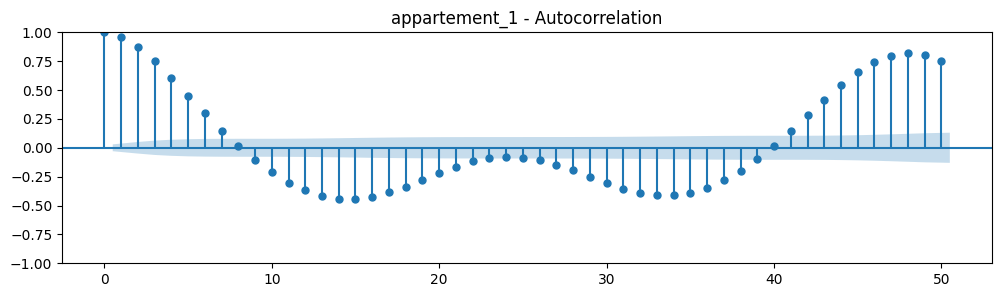

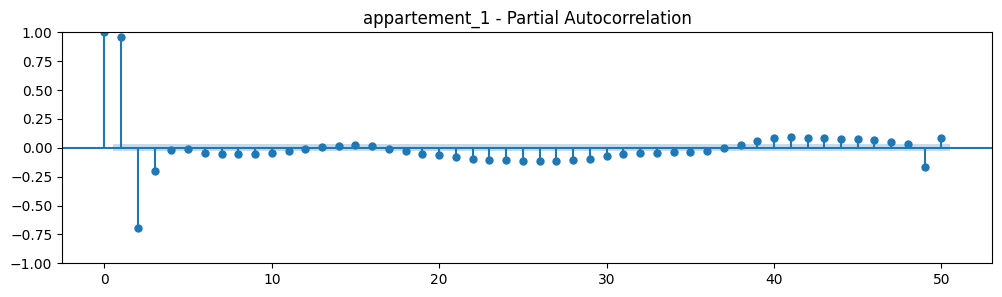

In [8]:
# Function to plot autocorrelation and partial autocorrelation
def plot_acf_pacf(data, lags=None, title=None):
    fig, ax = plt.subplots(figsize=(12, 3))

    # Autocorrelation plot
    sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax, title=title + " - Autocorrelation")
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 3))

    # Partial autocorrelation plot
    sm.graphics.tsa.plot_pacf(
        data, lags=lags, ax=ax, title=title + " - Partial Autocorrelation"
    )
    plt.show()

# Autocorrelation and partial autocorrelation plot for a specific apartment
selected_apartment = "appartement_1"
plot_acf_pacf(appartements[selected_apartment], lags=50, title=f"{selected_apartment}")

#### Time Series Analysis for Energy Consumption

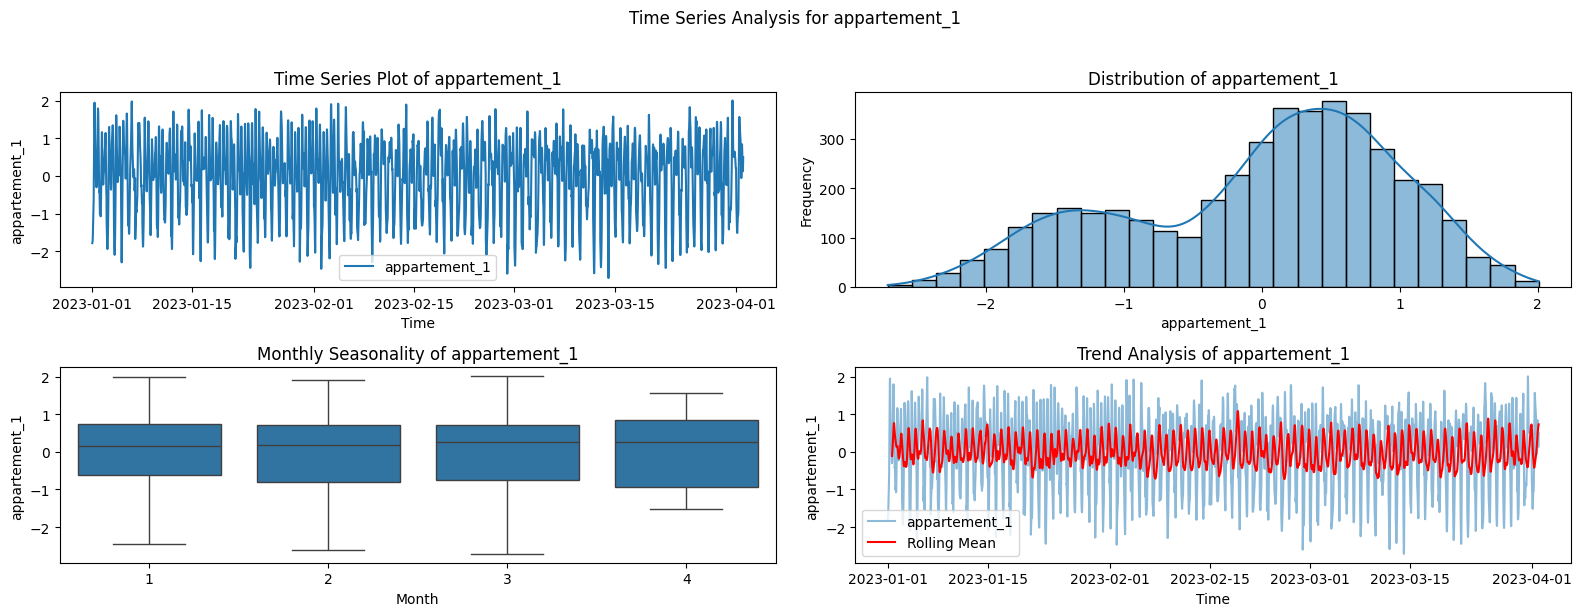

In [9]:
# Function to plot various time series visualizations
def plot_time_series_analysis(data, column, title=None):
    plt.figure(figsize=(16, 6))

    # Plot the time series data
    plt.subplot(2, 2, 1)
    sns.lineplot(data=data, x='Time', y=column, label=column)
    plt.title(f'Time Series Plot of {column}')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.legend()

    # Plot the distribution of the time series values
    plt.subplot(2, 2, 2)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    # Plot the seasonality using a boxplot
    plt.subplot(2, 2, 3)
    sns.boxplot(x=data['Time'].dt.month, y=data[column])  # Corrected the y parameter
    plt.title(f'Monthly Seasonality of {column}')
    plt.xlabel('Month')
    plt.ylabel(column)

    # Plot the rolling mean for trend analysis
    plt.subplot(2, 2, 4)
    rolling_mean = data[column].rolling(window=30).mean()  # Adjust the window as needed
    sns.lineplot(data=data, x='Time', y=column, label=column, alpha=0.5)
    sns.lineplot(data=data, x='Time', y=rolling_mean, label='Rolling Mean', color='red')
    plt.title(f'Trend Analysis of {column}')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.legend()

    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

# Selected apartment for analysis
selected_apartment = "appartement_1"

# Perform time series analysis for the selected apartment
plot_time_series_analysis(appartements, column=selected_apartment, title=f'Time Series Analysis for {selected_apartment}')

#### Correlation Matrix

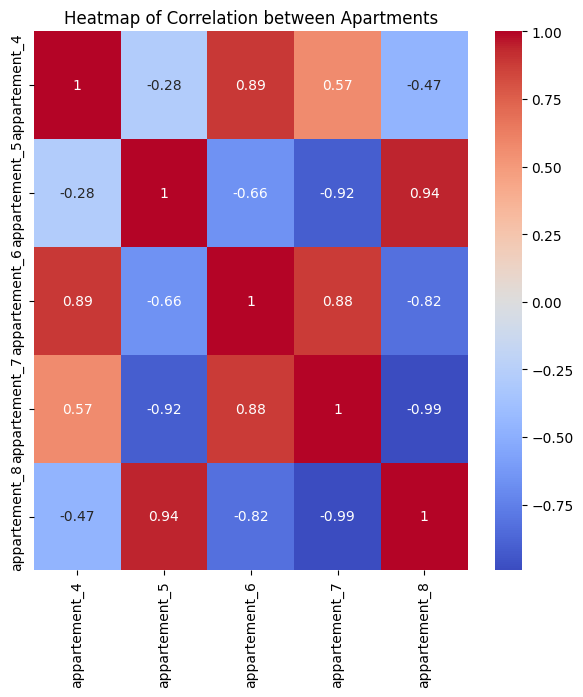

In [10]:
plt.figure(figsize=(7, 7))
sns.heatmap(appartements.iloc[4:9, 4:9].corr(), cmap='coolwarm', annot=True)
plt.title('Heatmap of Correlation between Apartments')
plt.show()

#### Autocorrelation and Partial Autocorrelation

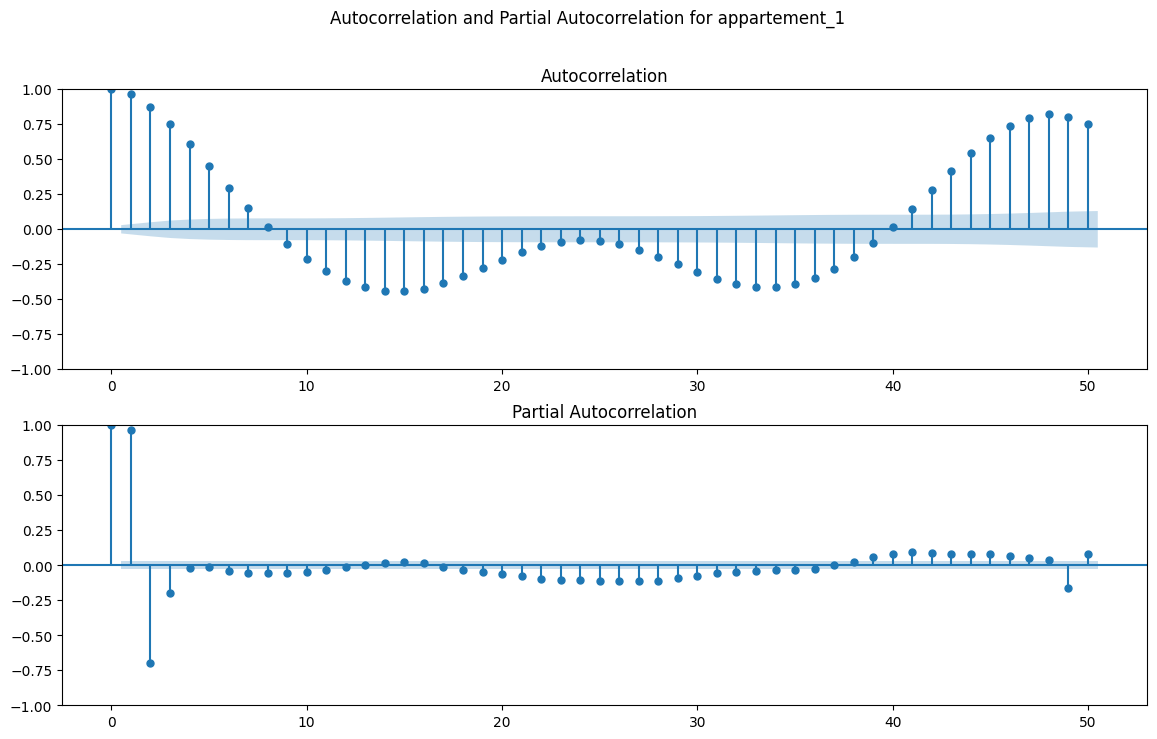

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
plot_acf(appartements[selected_apartment], lags=50, ax=axes[0])
plot_pacf(appartements[selected_apartment], lags=50, ax=axes[1])
plt.suptitle(f'Autocorrelation and Partial Autocorrelation for {selected_apartment}')
plt.show()

#### Seasonal Decomposition

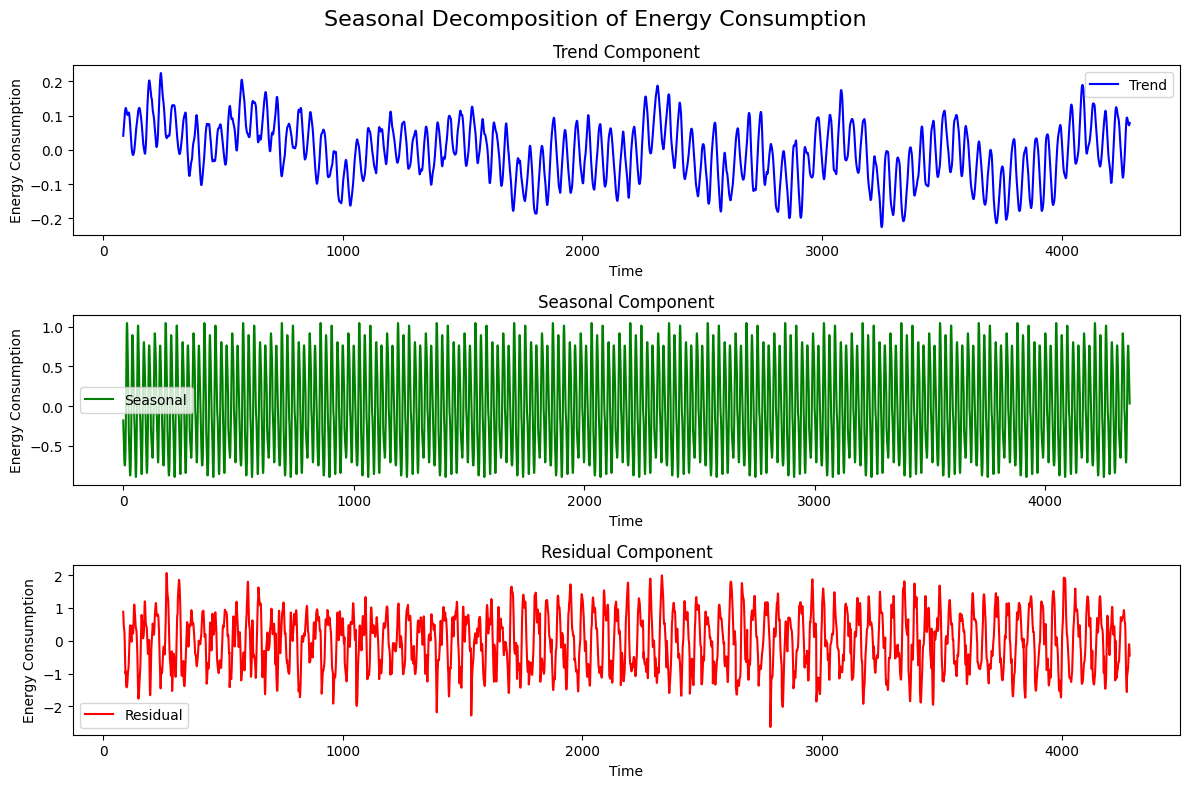

In [12]:
# Adjust the figure size for better visibility
plt.figure(figsize=(12, 8))

# Perform seasonal decomposition
result = seasonal_decompose(appartements[selected_apartment], model='additive', period=24*7)

# Plot the trend component
plt.subplot(3, 1, 1)
plt.plot(result.trend, label='Trend', color='blue')
plt.title('Trend Component')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()

# Plot the seasonal component
plt.subplot(3, 1, 2)
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()

# Plot the residual component
plt.subplot(3, 1, 3)
plt.plot(result.resid, label='Residual', color='red')
plt.title('Residual Component')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()

# Add a suptitle for the overall decomposition
plt.suptitle('Seasonal Decomposition of Energy Consumption', fontsize=16)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [13]:
df = appartements

In [15]:
# Aggregation journalière des données pour appartements
df_day = df.copy()  
df_day["Day"] = df_day['Time'].dt.strftime('%Y-%m-%d')  
df_day = df_day.drop(columns=['Time']).groupby(["Day"]).sum().reset_index()  


### **Normalisation**

Comme nous venons de le dire, nous sommes probablement plus intéressés par l'explication des différences fines de comportement entre consommateurs que par les différences " brutes " de consommation. Nous sommes beaucoup plus intéressés par la forme de leurs séries temporelles que par la moyenne de leurs valeurs, et donc la normalisation sur les différents profils nous a semblé être une bonne idée 


In [18]:
# Aggregation journalière des données pour appartements
df_day = df.copy()  
df_day["Day"] = df_day['Time'].dt.strftime('%Y-%m-%d')  
df_day = df_day.drop(columns=['Time']).groupby(["Day"]).sum().reset_index()  

df_to_scale = df_day.set_index("Day")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_to_scale)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,...,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01
mean,-3.172066e-17,-3.660076e-17,-9.150190e-18,-3.919331e-17,4.880101e-17,2.928061e-17,-2.440051e-18,-7.320152e-18,1.220025e-17,-2.684056e-17,...,-2.440051e-18,-1.570783e-17,3.172066e-17,-1.708035e-17,2.684056e-17,4.880101e-18,9.760202e-18,-2.135044e-17,-1.464030e-17,5.795120e-18
std,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,...,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00
min,-2.888745e+00,-3.265730e+00,-2.607497e+00,-1.853625e+00,-2.189280e+00,-2.443458e+00,-2.287049e+00,-2.198790e+00,-2.521146e+00,-2.421726e+00,...,-2.641514e+00,-2.401111e+00,-2.382653e+00,-3.703438e+00,-2.217479e+00,-2.039797e+00,-2.460237e+00,-2.885141e+00,-2.512289e+00,-3.518568e+00
25%,-5.981033e-01,-6.412752e-01,-5.767620e-01,-7.589852e-01,-6.650516e-01,-6.511284e-01,-6.059852e-01,-6.645619e-01,-8.057903e-01,-7.745588e-01,...,-6.473873e-01,-6.145505e-01,-5.518629e-01,-3.558065e-01,-6.745028e-01,-6.866298e-01,-6.273504e-01,-6.749090e-01,-6.095979e-01,-6.063911e-01
50%,2.090787e-01,1.176206e-01,1.928203e-02,3.529423e-02,-7.336114e-02,-6.923967e-02,-5.597430e-02,-1.093622e-01,9.744472e-02,-4.773094e-02,...,-5.422370e-02,5.370443e-02,-8.019602e-02,9.560399e-02,5.130790e-02,-1.032230e-01,7.876729e-02,-3.223327e-02,-1.186707e-01,-8.661057e-03
75%,6.390468e-01,6.336136e-01,8.027956e-01,7.084633e-01,7.675513e-01,5.080176e-01,6.081552e-01,6.168350e-01,6.109655e-01,6.087123e-01,...,6.018754e-01,5.802279e-01,4.902962e-01,5.929271e-01,6.357927e-01,5.972510e-01,6.828362e-01,7.260026e-01,7.529322e-01,7.256501e-01
max,2.756936e+00,2.777406e+00,1.986096e+00,2.398131e+00,2.694077e+00,2.687092e+00,2.132675e+00,2.512373e+00,2.696748e+00,2.664083e+00,...,2.522901e+00,2.400581e+00,3.948978e+00,2.189686e+00,2.775379e+00,2.908314e+00,2.385864e+00,2.134562e+00,2.448382e+00,2.450435e+00


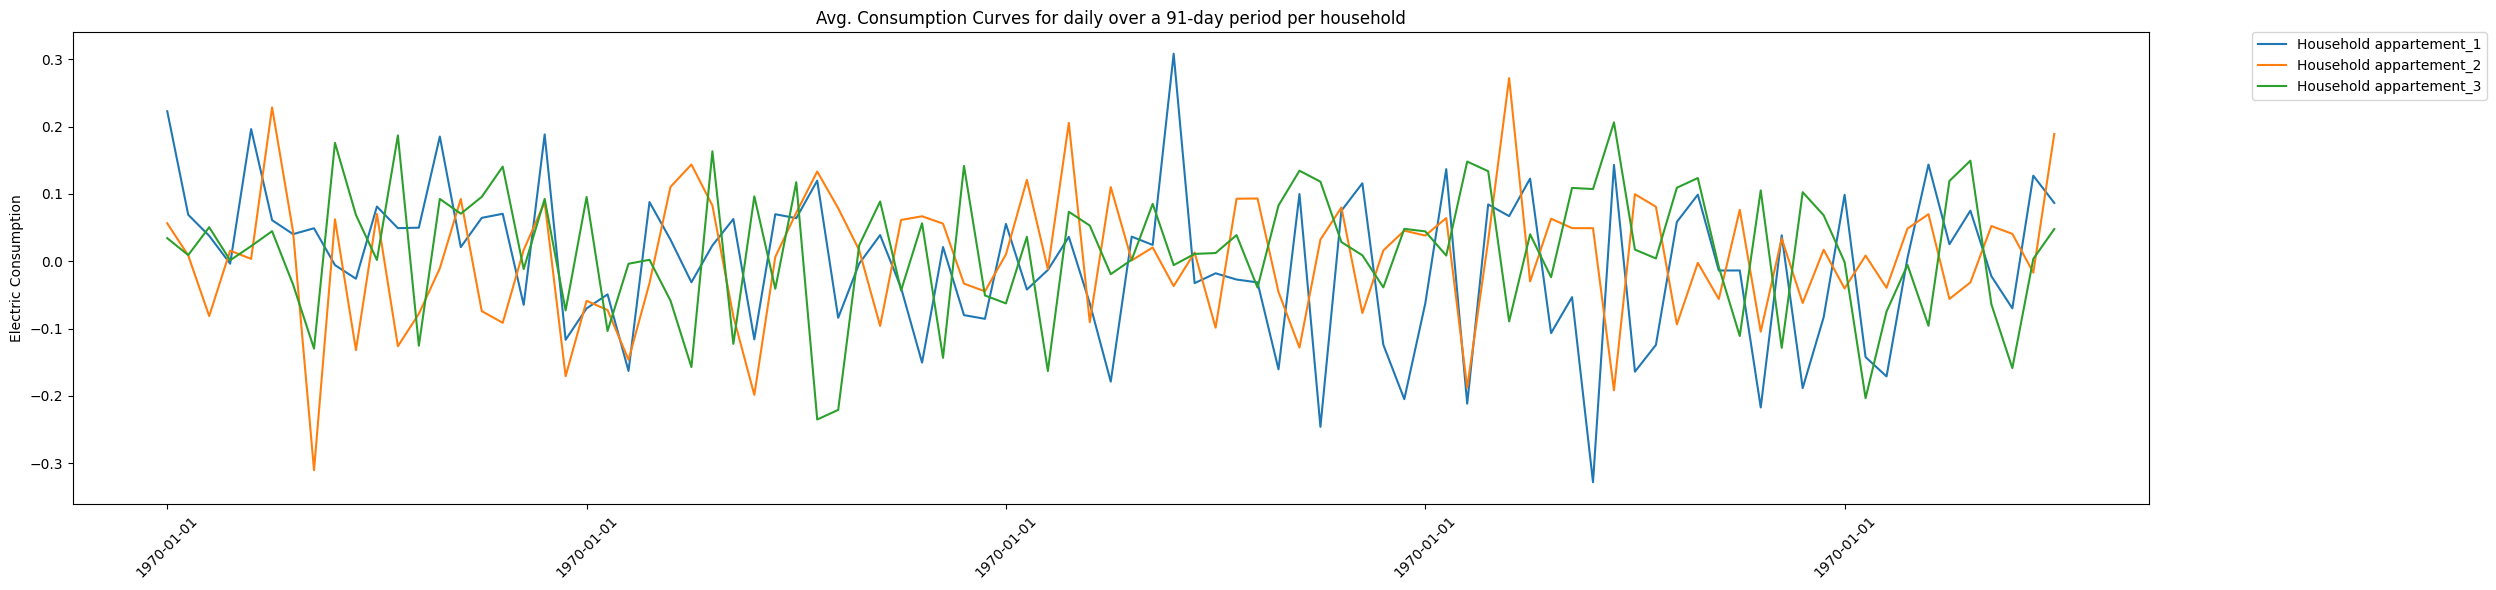

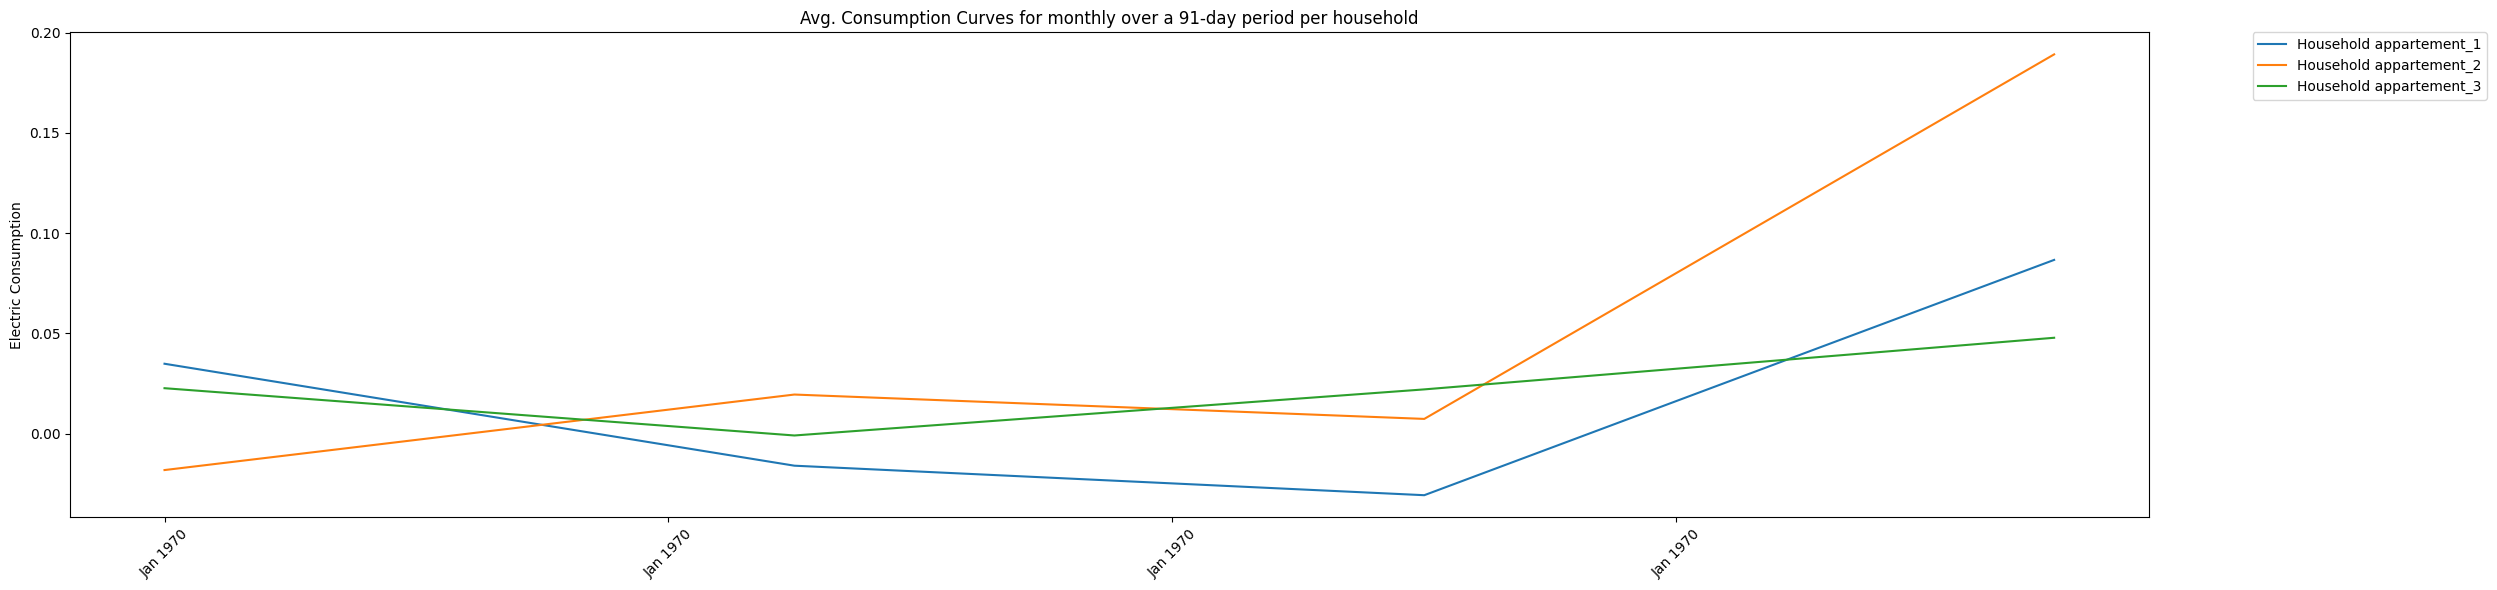

In [30]:
def plot_consumption_curves(data_frame, time_period, profiles):
    """
    Plot average electricity consumption curves for given time period and profiles.

    Parameters:
    - data_frame: DataFrame containing the electricity consumption data.
    - time_period: Time period for grouping data, "Month" or "Week".
    - profiles: List of profiles for which consumption curves are plotted.
    """

    # Make a copy of the DataFrame to avoid modification of the original
    df_copy = data_frame.copy()

    # Define parameters based on the time period
    date_length = 7 if time_period == "Month" else 10
    mode = "monthly" if time_period == "Month" else "daily"

    # Extract and group data based on the specified time period
    df_copy[time_period] = df_copy["Time"].astype("str").str[5:date_length]
    df_copy = df_copy.groupby(time_period).mean()

    # Create a figure for the plot
    fig, ax = plt.subplots(figsize=[25, 6])
    ax.set_ylabel("Electric Consumption")
    ax.set_title(f"Avg. Consumption Curves for {mode} over a 91-day period per household")

    # Use the "tab10" colormap for distinct and easily distinguishable colors
    colors = plt.cm.tab10.colors[:len(profiles)]

    for profile, color in zip(profiles, colors):
        ax.plot(df_copy.index, df_copy[profile], label=f"Household {profile}", color=color)

    # Configure x-axis ticks and labels for better readability
    date_format = '%b %Y' if time_period == 'Month' else '%Y-%m-%d'
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: pd.to_datetime(x).strftime(date_format)))

    # Display legend, adjust layout, and show the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
plot_consumption_curves(data_frame=df, time_period="Day", profiles=["appartement_1", "appartement_2", "appartement_3"])
plot_consumption_curves(data_frame=df, time_period="Month", profiles=["appartement_1", "appartement_2", "appartement_3"])

# **4. Reduction de dimension & Extraction des caractéristiques**

Cette partie est consacrée aux techniques permettant la réduction de dimension et l'extraction des caractéristiques.

Tout d'abord, afin de pouvoir établir des profils de consommation, il est important de réduire notre nombre de caractéristiques et d'agréger nos données, afin d'y voir plus clair. L'agrégation de la consommation par mois ou par jour était une façon de réduire la dimensionnalité, de façon très grossière et arbitraire, mais elle montre que pour réussir le problème de clustering et éviter que les algorithmes ne soient trop longs, il faut représenter les séries temporelles de consommation par des indicateurs, moins nombreux, mais avec le moins de variance possible. Il est nécessaire d'extraire de cette série ce qui la caractérise le plus, afin d'obtenir un clustering réellement efficace.

Nous avons identifié 3 façons possibles de réduire la dimension de nos données et d'extraction des caractéristiques :
1. Premièrement, appliquer un **ACP** sur les données, afin d'optimiser mathématiquement la perte de variance, mais sans avoir de caractéristiques interprétables.
2. Recréer nos propres caractéristiques, en s'inspirant des techniques d'analyse des séries temporelles. Cela nous permet cette fois d'avoir des caractéristiques très facilement interprétables, mais pas nécessairement optimisées pour le clustering.
3. La **Transformation de Fourier**


### **3.1 Principal component analysis (PCA)**
L'objectif de l'analyse en composantes principales est de représenter un nuage de points par sa projection sur le sous-espace affine de dimension k minimisant l'inertie. Ici, nous avons près de 4368 données différentes pour chacun des foyers, et nous aimerions réduire à un nombre de caractéristiques suffisant pour expliquer 90% de la variabilité des données.

Pour que l'ACP fonctionne, nous devons à nouveau normaliser les données, mais cette fois-ci par **caractéristiques**. En effet, sans cette normalisation, l'ACP ne sélectionnerait que les caractéristiques ayant le plus de variance, car garder ces caractéristiques permet de garder le plus de variance possible. Dans notre cas, cela reviendrait à ne regarder que les moments où il y a le plus de différences brutes de consommation, ce que nous ne voulons pas, car nous voulons identifier et cibler les différences de comportement à tout moment.

Ceci permet que certaines dates ne prennent pas plus d'importance que d'autres, et donc que l'ACP permette de faire une réelle réduction de dimension. 


In [19]:
scaler_acp = StandardScaler()

df_scaled_to_acp = scaler_acp.fit_transform(df_scaled.transpose())

df_scaled_to_acp = pd.DataFrame(df_scaled_to_acp)

df_scaled_to_acp.describe()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,...,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,-3.358425e-17,-1.956768e-17,4.107825e-17,-2.886580e-17,-7.660539e-17,-4.024558e-18,-1.165734e-16,-1.887379e-17,3.247402e-17,4.996004e-18,...,2.465042e-17,5.107026e-17,2.498002e-18,-4.218847e-17,3.677614e-17,-4.440892e-17,1.998401e-17,7.938095e-17,-6.883383e-17,-7.105427e-17
std,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,...,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00
min,-2.340248e+00,-2.650680e+00,-2.735055e+00,-2.149471e+00,-2.803177e+00,-2.471829e+00,-2.817411e+00,-3.075279e+00,-2.993520e+00,-2.899892e+00,...,-2.365727e+00,-2.346267e+00,-2.639807e+00,-2.467038e+00,-2.821334e+00,-1.893604e+00,-2.197805e+00,-1.977091e+00,-3.080774e+00,-2.717028e+00
25%,-6.929974e-01,-5.457336e-01,-6.796781e-01,-5.221553e-01,-6.050446e-01,-7.314096e-01,-6.852457e-01,-5.763264e-01,-6.839264e-01,-6.799468e-01,...,-5.867771e-01,-6.667655e-01,-6.817302e-01,-6.848685e-01,-7.985926e-01,-7.958040e-01,-5.805334e-01,-7.110709e-01,-6.617010e-01,-6.722441e-01
50%,-4.145874e-02,1.923822e-02,-3.067843e-02,-4.342826e-02,1.309274e-01,1.258871e-01,9.701606e-03,4.364113e-02,2.513445e-02,1.442338e-01,...,-5.770850e-02,5.651883e-02,3.630989e-03,-8.522491e-02,1.155653e-03,-1.514149e-01,-9.463222e-02,-3.051468e-02,3.308866e-03,1.322785e-01
75%,6.618519e-01,5.778678e-01,6.306636e-01,5.533096e-01,7.250219e-01,5.835691e-01,6.520393e-01,5.939330e-01,5.659823e-01,6.371207e-01,...,7.326426e-01,5.811675e-01,6.434752e-01,5.126661e-01,6.685408e-01,6.449807e-01,4.951141e-01,8.215754e-01,7.142641e-01,6.456870e-01
max,2.296146e+00,2.509379e+00,2.611311e+00,3.900113e+00,2.009252e+00,2.546364e+00,2.577429e+00,2.202448e+00,2.238482e+00,2.062382e+00,...,2.094321e+00,2.516738e+00,2.526539e+00,2.331427e+00,2.613661e+00,2.503186e+00,3.295281e+00,2.389558e+00,2.306777e+00,2.685144e+00


Nos données sont bien normalisées par point dans le temps, donc nous pouvons appliquer notre ACP.

In [21]:
from sklearn.decomposition import PCA

acp = PCA(n_components = 0.95) #Nous souhaitons garder 90% de la variance.
df_acp = pd.DataFrame(acp.fit_transform(df_scaled_to_acp))
df_acp

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,-3.135196,-0.164678,-0.364578,0.637250,-1.517390,2.734195,0.091045,2.571666,3.445291,-0.021527,...,-0.912928,0.148927,-0.755206,-0.119357,0.535406,1.092307,0.089899,-1.074330,0.215514,0.416995
1,0.361574,-1.540512,-0.805996,1.019425,1.393532,1.210297,-1.267075,-2.057341,2.070642,-0.641823,...,-1.561061,-1.164648,-0.803681,-1.594502,0.188696,0.461578,-1.731338,0.184483,0.153189,-0.333632
2,1.352010,-2.113286,5.751091,0.326116,-0.630978,-0.315415,0.117600,1.873658,0.147565,1.508805,...,0.633654,-0.071685,0.230498,-0.477237,-0.387314,0.299658,-0.106939,-1.130953,-0.571819,0.430543
3,0.509122,-0.888116,-0.716910,-1.947217,2.980348,2.435678,0.473574,0.676666,0.498984,1.324784,...,-0.321958,0.267999,-0.174502,-0.681937,0.452348,-0.302225,0.017653,1.009503,-0.354199,-0.539339
4,0.799264,-0.778398,0.733101,2.200302,-0.660283,0.764601,-0.767409,0.775638,0.155449,-2.041821,...,-0.538710,-1.157264,-0.457921,-0.533198,1.107204,0.738465,0.826037,-0.638642,-0.291829,-0.472930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.967471,-3.994461,-0.957901,-0.483841,0.594827,-0.931804,0.963131,0.928729,-3.972046,-0.700392,...,-0.416982,0.339729,-0.695007,1.279496,0.260870,0.466660,0.410755,0.354310,-1.164582,-0.250947
96,3.508073,-2.531584,-1.602166,-0.921093,-3.134862,0.460745,1.980639,3.459347,-1.165066,-0.128125,...,-0.991136,-1.004982,0.352877,0.821615,-0.908209,0.175213,-0.142374,-0.009756,-0.362986,-1.248225
97,-2.319496,-0.514849,0.311074,1.813810,0.358833,-1.734074,0.494962,0.969565,-1.562841,-0.599303,...,-0.110512,-0.652420,1.557378,-0.217810,0.681481,0.734226,0.331544,-0.031314,-0.159291,0.004455
98,-1.348713,1.518560,0.402513,-2.150179,-0.025476,-2.258834,0.329800,1.732987,2.340974,-1.512598,...,-0.011236,0.281746,0.265207,1.198885,1.566206,-0.190689,-0.331772,0.014448,0.427796,0.842475


In [22]:
df_day[df_day.columns[1:]].transpose()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
appartement_1,10.695612,3.317783,1.816731,-0.170942,9.427071,2.930542,1.934942,2.353858,-0.273517,-1.242295,...,-6.830205,-8.209448,0.239532,6.896935,1.217387,3.610276,-1.061290,-3.357077,6.104533,4.159973
appartement_2,2.707761,0.418042,-3.906145,0.755987,0.170686,10.968174,2.124044,-14.896906,2.993616,-6.331903,...,0.404758,-1.891170,2.332111,3.354595,-2.685411,-1.506695,2.510267,1.955998,-0.806511,9.079757
appartement_3,1.647498,0.443568,2.425824,0.070307,1.081296,2.144220,-1.654045,-6.224277,8.443819,3.298806,...,-9.759574,-3.584769,-0.256895,-4.600055,5.728715,7.172459,-3.063426,-7.615720,0.171141,2.296061
appartement_4,-5.904153,3.828257,-3.463101,-1.734172,1.078066,-1.762765,-0.364210,-6.221714,-1.984162,7.700487,...,5.868654,-0.592517,3.422490,1.682658,5.671725,8.118207,0.056982,9.015118,1.130749,-0.086091
appartement_5,-2.661249,1.062960,-2.683973,4.439202,-1.972080,-3.779524,-2.358911,-3.909017,4.111384,-6.585456,...,-5.118859,2.316118,-2.225060,6.086256,-2.855952,11.064555,7.715690,-9.530006,-0.444708,-7.872315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
appartement_96,-7.802755,-1.167473,-6.746188,0.063060,7.866515,-2.985956,-2.069785,-4.042272,-2.063538,-0.984810,...,10.657842,0.740355,1.377736,2.586574,-0.517464,6.339430,3.419279,0.079421,0.311444,-2.374568
appartement_97,-5.488774,-2.837245,-6.590368,-10.240349,1.337738,0.771130,-3.741647,1.316304,2.465821,-0.945893,...,0.124952,-5.760185,-7.500686,5.444726,5.448364,1.556130,3.664351,7.062429,3.052979,11.845600
appartement_98,2.512723,2.296679,-1.203642,8.447088,-4.375373,3.136551,1.835797,6.877287,-3.486919,7.138340,...,-5.609893,-6.933730,-7.379604,-3.440074,-4.160071,-4.070036,-2.886960,-4.309335,-4.591106,-1.789723
appartement_99,0.038179,-0.674502,1.757036,0.233395,2.891689,10.142720,-5.419609,-0.754560,-0.961512,10.586027,...,-5.237551,6.052877,-2.703786,-0.588804,9.513308,-4.526390,0.246741,4.342880,12.513442,7.408875


Nous obtenons un cadre de données qui ne contient que 81 caractéristiques (non interprétables), tout en conservant 90% de la variance.

### **3.2 Dimension reduction based on time series features**

Dans cette partie, nous prenons tout le contraire de l'ACP en **créant cette fois des variables interprétables** pour chaque individu, comme la moyenne de sa consommation, le minimum ou le maximum de la consommation d'un individu.

Nous travaillons ici sur des données **non normalisées** par individus. En effet, il nous a semblé plus pertinent de conserver des chiffres bruts pour mieux extraire certaines différences entre les consommateurs. De plus, la plupart des caractéristiques que nous allons recréer sont des caractéristiques basées sur le fait qu'il existe des différences brutes, tel que la consommation moyenne de chaque individu. 

In [31]:
df1 = df.transpose()
liste_des_profils = df.columns[1:]
#supprimer la première ligne qui correspond au time range afin de ne garder que les lignes representant les 100 menages
df1 = df1.drop(['Time'])

In [32]:
df_features = pd.DataFrame()
df_features["Moyenne"] = df1.apply(np.mean, 1) 
df_features["Minimum"] = df1.apply(min, 1)
df_features["Maximum"] = df1.apply(max, 1)

In [33]:
# Aggregation mensuel des données pour appartements
df_month = df.copy()
df_month['Month'] = df_month['Time'].dt.month 
df_month = df_month.drop(columns=['Time']).groupby('Month').sum()  

df_features["mois_conso_max"] = [df_month[profil].idxmax() for profil in liste_des_profils]
df_features["mois_conso_min"] = [df_month[profil].idxmin() for profil in liste_des_profils]
df_features["jour_conso_max"] = [df_day[profil].idxmax() for profil in liste_des_profils]
df_features["jour_conso_min"] = [df_day[profil].idxmin() for profil in liste_des_profils]

In [34]:
df_features

,Moyenne,Minimum,Maximum,mois_conso_max,mois_conso_min,jour_conso_max,jour_conso_min
appartement_1,-0.002530,-2.712846,2.007661,1,3,48,68
appartement_2,0.004413,-2.447783,1.964942,2,1,64,7
appartement_3,0.015500,-2.551442,1.927615,1,2,69,31
appartement_4,0.006204,-2.653337,2.054251,3,1,59,16
appartement_5,-0.015020,-2.467466,2.030829,3,1,86,19
...,...,...,...,...,...,...,...
appartement_96,0.012919,-2.379652,2.264872,3,4,22,49
appartement_97,-0.003102,-2.649557,2.107669,3,1,90,37
appartement_98,-0.006116,-2.731046,2.094527,1,3,20,59
appartement_99,0.005128,-2.532689,1.971988,3,2,89,68


Maintenant que nous avons créé nos propres caractéristiques à la main, il est important de les normaliser : en effet, la plupart des algorithmes de clustering se basent sur la norme euclidienne pour créer des clusters, donc toutes nos caractéristiques doivent avoir le même ordre de grandeur afin que certaines d'entre elles ne prennent pas plus de place que d'autres dans le clustering.

### **3.3 La transformation de Fourier**

In [35]:
data_FT = df_day[['Day', 'appartement_1','appartement_10','appartement_20']]



appt1_fft = np.fft.fft(np.asarray(data_FT['appartement_1'].tolist()))
fft_df = pd.DataFrame({'fft':appt1_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

In [36]:
fft_df.head()

,fft,absolute,angle
0,-11.051176+ 0.000000j,11.051176,3.141593
1,62.431061-63.035419j,88.719228,-0.790215
2,56.729333-41.752101j,70.437598,-0.634473
3,29.104118-13.174470j,31.947087,-0.425069
4,28.761462-14.978698j,32.428122,-0.480141


C:\Users\SALHI YOUSSEF\Downloads\Project_unsupervised\project_unsp\unsupervised-learning-project\venv\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\SALHI YOUSSEF\Downloads\Project_unsupervised\project_unsp\unsupervised-learning-project\venv\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


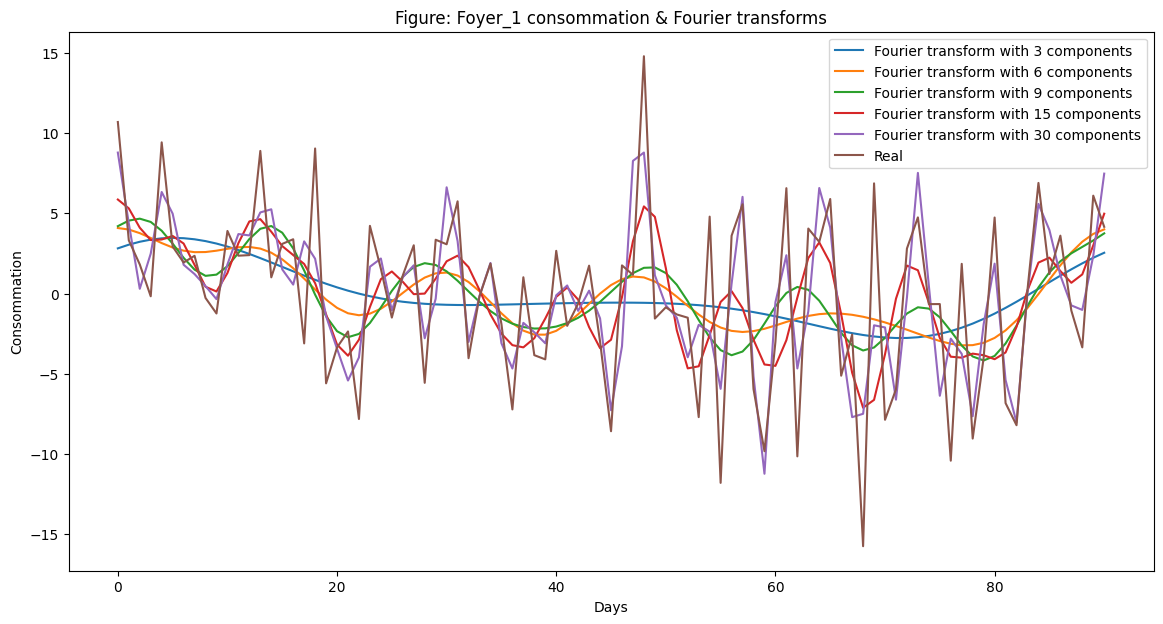

In [37]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 15,30]:
    fft_list_m10= np.copy(fft_list); 
    fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['appartement_1'],  label='Real')
plt.xlabel('Days')
plt.ylabel('Consommation')
plt.title('Figure: Foyer_1 consommation & Fourier transforms')
plt.legend()
plt.show()

In [38]:
appt10_fft = np.fft.fft(np.asarray(data_FT['appartement_10'].tolist()))
fft_df = pd.DataFrame({'fft':appt10_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

C:\Users\SALHI YOUSSEF\Downloads\Project_unsupervised\project_unsp\unsupervised-learning-project\venv\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\SALHI YOUSSEF\Downloads\Project_unsupervised\project_unsp\unsupervised-learning-project\venv\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


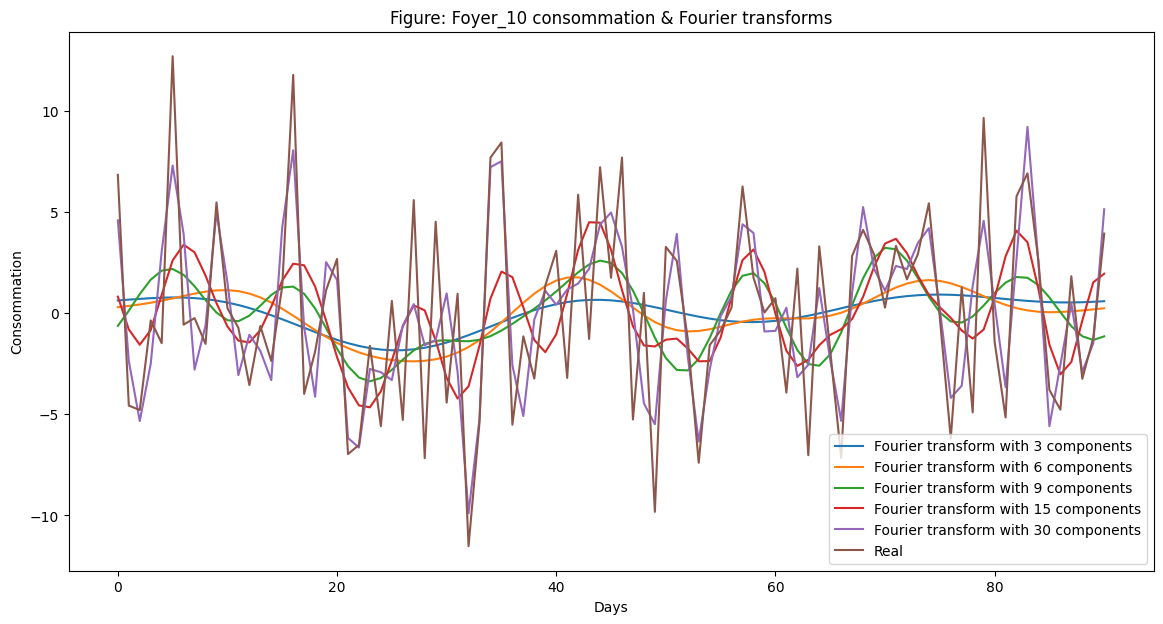

In [39]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 15,30]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['appartement_10'],  label='Real')
plt.xlabel('Days')
plt.ylabel('Consommation')
plt.title('Figure: Foyer_10 consommation & Fourier transforms')
plt.legend()
plt.show()

In [40]:
appt3_fft = np.fft.fft(np.asarray(data_FT['appartement_20'].tolist()))
fft_df = pd.DataFrame({'fft':appt3_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

C:\Users\SALHI YOUSSEF\Downloads\Project_unsupervised\project_unsp\unsupervised-learning-project\venv\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\SALHI YOUSSEF\Downloads\Project_unsupervised\project_unsp\unsupervised-learning-project\venv\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


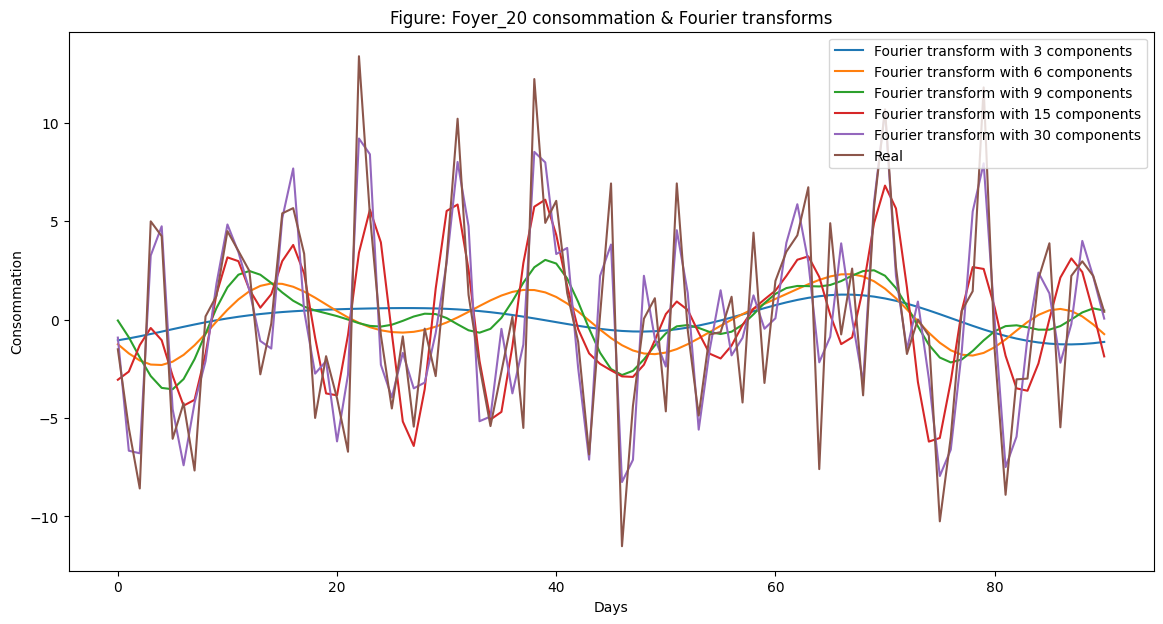

In [41]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 15,30]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['appartement_20'],  label='Real')
plt.xlabel('Days')
plt.ylabel('Consommation')
plt.title('Figure: Foyer_20 consommation & Fourier transforms')
plt.legend()
plt.show()

La transformation de Fourier utilise de nombreuses composantes spectrales pour essayer de former les données. Du domaine temporel, elles sont converties en domaine fréquentiel, puis calculées. Après cela, elle est reconvertie dans le domaine temporel où elle est tracée. La transformation de Fourier en tant qu'indicateur permet d'extraire le cycle prédominant d'une série de données.

Référence : https://www.metastock.com/customer/resources/taaz/?p=58

Dans les exemples ci-dessus, nous pouvons voir que la composante spectrale de 30 est la plus proche de la consommation réelle, nous allons donc avancer avec 30.

In [42]:
def get_fourier(dataset):
    data_FT = dataset[df_day.columns.to_list()]
    num_appt=0
    for i in data_FT.columns[1:].tolist():
      num_appt=num_appt+1
      close_fft = np.fft.fft(np.asarray(data_FT[i].tolist()))
      close_fft = np.fft.ifft(close_fft)
      close_fft
      fft_df = pd.DataFrame({'fft':close_fft})
      fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
      fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
      fft_list = np.asarray(fft_df['fft'].tolist())
      fft_list_m10= np.copy(fft_list); fft_list_m10[30:-30]=0
      col_name='Fourier_'+str(num_appt)
      dataset[col_name] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))
    #dataset['absolute'] = dataset['Fourier'].apply(lambda x: np.abs(x))
    return dataset

In [43]:
dataset=df_day.copy()
dataset_TI_df = get_fourier(dataset)
dataset_TI_df.head()

C:\Users\SALHI YOUSSEF\AppData\Local\Temp\ipykernel_21152\2330888158.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[col_name] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))
C:\Users\SALHI YOUSSEF\AppData\Local\Temp\ipykernel_21152\2330888158.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[col_name] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))


,Day,appartement_1,appartement_2,appartement_3,appartement_4,appartement_5,appartement_6,appartement_7,appartement_8,appartement_9,...,Fourier_91,Fourier_92,Fourier_93,Fourier_94,Fourier_95,Fourier_96,Fourier_97,Fourier_98,Fourier_99,Fourier_100
0,2023-01-01,10.695612,2.707761,1.647498,-5.904153,-2.661249,0.654775,-1.157198,-2.259596,2.908255,...,3.991519,1.734392,0.876962,2.435284,1.460960,7.802755,5.488774,2.512723,0.038179,1.193993
1,2023-01-02,3.317783,0.418042,0.443568,3.828257,1.062960,1.491268,-0.203413,0.929008,8.298131,...,2.156356,1.475652,1.986360,1.328565,3.933832,1.167473,2.837245,2.296679,0.674502,0.483624
2,2023-01-03,1.816731,-3.906145,2.425824,-3.463101,-2.683973,11.444573,0.517418,0.066906,1.924546,...,12.081914,4.045812,3.777372,3.555868,1.854796,6.746188,6.590368,1.203642,1.757036,4.484738
3,2023-01-04,-0.170942,0.755987,0.070307,-1.734172,4.439202,6.108568,-5.108810,2.151468,4.823757,...,0.404964,2.223912,1.802795,4.237884,7.549328,0.063060,10.240349,8.447088,0.233395,6.750551
4,2023-01-05,9.427071,0.170686,1.081296,1.078066,-1.972080,-5.661369,3.067871,1.375589,-5.263518,...,3.896672,1.863383,3.898508,5.057182,4.731564,7.866515,1.337738,4.375373,2.891689,5.147485


# **4. Clustering**

**4.1 Classification Hierachique**

Nous commençons par un regroupement par classification hiérarchique. L'avantage d'une telle technique est que nous pouvons décider ici de couper le dendogramme à l'endroit souhaité, pour obtenir des groupes de la taille désirée.

**a- Méthodes basées sur extraction des caractéristiques**

 Afin d'évaluer nos résultats, nous utilisons l'indice Calinski Harabasz. 

In [ ]:
# Aggregation mensuel des données pour appartements
df_month = df.copy()
df_month["Month"] = df_month["Time"].dt.month
df_month = df_month.drop(columns=["Time"]).groupby("Month").sum()

# Aggregation journalière des données pour appartements
df_day = df.copy()
df_day["Day"] = df_day["Time"].dt.strftime("%Y-%m-%d")
df_day = df_day.drop(columns=["Time"]).groupby(["Day"]).sum().reset_index()

# Aggregation hebdomadaire des données pour appartements
df_week = df.copy()
df_week["Week"] = df_week["Time"].dt.strftime(
    "%Y-%U"
)  # Formatage de la date pour extraire la semaine
df_week = df_week.drop(columns=["Time"]).groupby(["Week"]).sum().reset_index()

In [ ]:
df_day.head()

### 2.4- Representation Graphique des données à une échelle mensuelle et Journalière

Maintenant tout est en place pour pouvoir représenter graphiquement les courbes de consommation. 
Nous implémentons ci-dessous une fonction **graph_consos** qui nous permet d'afficher les profils que nous voulons, en agrégeant **par la moyenne des données individuelles au niveau mensuel ou journalier**. 

In [ ]:
def graph_consos(DataFrame, time, liste_profils):
    x = DataFrame.copy()
    temp = df.copy()
    # On utilise la fonction copy pour ne pas modifier le DataFrame considéré
    if time == "Month":
        k = 7  # mois
        s = 1
        mode = "mensuelle"
    else:
        k = 10  # jours
        s = 31
        mode = "journalière"

    temp[time] = temp["Time"].astype("str").str[5:k]
    temp = temp.groupby(time).mean()
    x[time] = x["Time"].astype("str").str[5:k]
    x = x.groupby(time).mean()

    fig = plt.figure(figsize=[12, 4.8])
    a1 = fig.add_axes([0, 0, 1, 1])
    a1.set_ylabel("Consommation électrique")
    plt.xticks(rotation=55)
    plt.title("Courbes de consommation moyenne %s sur un 91 jours par foyer" % mode)

    for profil in liste_profils:
        plt.plot(
            x[profil], label="Foyer %s" % profil
        )  # boucle if qui permet de toujours avoir une belle légende

    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()


graph_consos(
    DataFrame=df,
    time="Week",
    liste_profils=["appartement_1", "appartement_2", "appartement_3"],
)
graph_consos(
    df, time="Month", liste_profils=["appartement_1", "appartement_2", "appartement_3"]
)

L'agrégation des données à une échelle mensuelle / journalière semble écraser considérablement la variabilité des données, mais elle donne un aperçu des habitudes de consommation des différents ménages, et constitue une première technique d'agrégation des données. 
Afin de pouvoir analyser des comportements plus fins et plus subtils, nous pouvons aussi regarder des courbes tq la consommation journalière moyenne de certains ménages. 

-> La fonction ci-dessous nous permet de représenter **la semaine de consommation de notre choix pour un ménage**. 


In [ ]:
def graph_conso_semaine(DataFrame, liste_profils, semaine, plot):
    x = DataFrame.copy()
    temp = df.copy()
    x = x.drop(columns="Time")
    temp = temp.drop(columns="Time")

    n = x.shape[0]

    if semaine > n / (7 * 48):
        return "Semaine trop grande"
    else:
        init = (
            (semaine - 1) * 7 * 48
        )  # 7 jours dans la semaine et 48 fois une demi-heure par jour
        end = init + 7 * 48
        data = x.iloc[init:end]
        temperature = temp.iloc[init:end]

    if plot == True:
        fig = plt.figure(figsize=[12, 4.8])
        a1 = fig.add_axes([0, 0, 1, 1])
        a1.set_ylabel("Consommation électrique")
        plt.title("Courbes de consommations prises sur une semaine")
        plt.xticks(np.arange(init, end, step=48), calendar.day_name[0:8], rotation=20)
        for profil in liste_profils:
            plt.plot(data[profil], label="Foyer %s" % profil)

        plt.legend(bbox_to_anchor=(1.05, 1))
        return plt.show()
    else:
        return (
            pd.DataFrame(data[profil] for profil in liste_profils)
            .transpose()
            .reset_index(drop=True)
        )


graph_conso_semaine(
    df,
    ["appartement_1", "appartement_4", "appartement_6", "appartement_8"],
    12,
    plot=True,
)

La fonction graphique précedente nous permet de mieux comprendre le comportement des différents profils. Sur le graphique obtenu, celui qui montre la consommation sur une semaine donnée, les pics sont relativement élevés, on remarque notamment que les consommation des 4 foyers varie beaucoup.  Le graphique semble suggérer ici que appt_8 mange chez lui à midi le Lundi et Jeudi et utilise des appareils ménagers, tandis que appt_4 ne rentre chez lui que le soir, bien qu'il consomme beaucoup plus le soir. Il semble aussi que appt_6 consomme l'electricité beaucoup plus le matin (peut-être qu'il allume la télévison ou qu'il utilise d'autres appareil qui consomme l'electricité le matin). Nous pouvons même remarquer que l'ensemble des ménages consomme beaucoup plus l'energie electrique le week-end surtout le Samedi; cela peut-être expliquer par le fait qu'ils passent souvent plus de temps chez eux le week-end.

En géneral, les fonctions graphiques précédentes seront très utiles pour visualiser les différences entre les différents groupes obtenus par notre clustering. Nous en implémentons une dernière qui permet de visualiser la consommation moyenne par jour.

In [ ]:
import datetime
import matplotlib.dates as mdates

liste_des_jours = pd.unique(df["Time"].astype("str").str[5:10])


def valeurs_journee(df, profil, journee):
    df_day = df[df["Time"].astype("str").str[5:10] == journee][profil]
    d1 = pd.DataFrame(df_day).reset_index(drop=True)
    return d1


def journee_moyenne(df, profil):
    d1 = valeurs_journee(df, profil, liste_des_jours[0])
    for jour in liste_des_jours[1:]:
        d2 = valeurs_journee(df, profil, jour)
        d1 = pd.concat([d1, d2], axis=1)
    d1 = d1.apply(np.mean, 1)
    return pd.DataFrame(d2)


def journee_moyenne_liste(df, liste_profils, plot):
    if plot == True:
        fig = plt.figure(figsize=[12, 4.8])
        for profil in liste_profils:
            plt.plot(journee_moyenne(df, profil), label="Foyer %s" % profil)
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.xticks(np.arange(0, 50, step=2), np.arange(25))
        return plt.show()

    else:
        d1 = journee_moyenne(df, liste_profils[0])
        for profil in liste_profils[1:]:
            d2 = journee_moyenne(profil)
            d1 = pd.concat([d1, d2], axis=1)
        return d1


journee_moyenne_liste(
    df,
    [
        "appartement_20",
        "appartement_30",
        "appartement_60",
        "appartement_80",
        "appartement_90",
        "appartement_10",
    ],
    plot=True,
)


L'exemple ci-dessus nous montre que **probablement** nos données ne présentent pas une variation forte de la consommation brute entre les individus : les courbes suggérent qu'il y en a pas un leger dépassement entre la consommation d'un ménage d'un autre. Les différences de comportement entre les menages sont beaucoup moins évidentes visuellement parlant. **Mais** cela n'est déduit qu'en se basant sur un ensemble réduit de ménages, rien ne peut nous assurer que c'est le cas pour toutes les données. Donc **afin d'éviter** le fait que notre algorithme de clustering aussi identifie la consommation des ménages qui sont beaucoup plus élevée que les autres en faisant un groupe avec et un autre avec les ménages à faible consommation ET **afin de se concentrer sur les différences de comportement**, il pourrait être intéressant de normaliser chaque courbe afin que les différences de consommation brutes ne soient pas identifiées par l'algorithme de clustering.  

### **Normalisation**

Comme nous venons de le dire, nous sommes probablement plus intéressés par l'explication des différences fines de comportement entre consommateurs que par les différences " brutes " de consommation. Nous sommes beaucoup plus intéressés par la forme de leurs séries temporelles que par la moyenne de leurs valeurs, et donc la normalisation sur les différents profils nous a semblé être une bonne idée 



In [17]:
# Aggregation journalière des données pour appartements
df_day = df.copy()  
df_day["Day"] = df_day['Time'].dt.strftime('%Y-%m-%d')  
df_day = df_day.drop(columns=['Time']).groupby(["Day"]).sum().reset_index()  

df_to_scale = df_day.set_index("Day")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_scaled = scaler.fit_transform(df_to_scale)

df_scaled = pd.DataFrame(df_scaled)

df_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,...,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01,9.100000e+01
mean,-3.172066e-17,-3.660076e-17,-9.150190e-18,-3.919331e-17,4.880101e-17,2.928061e-17,-2.440051e-18,-7.320152e-18,1.220025e-17,-2.684056e-17,...,-2.440051e-18,-1.570783e-17,3.172066e-17,-1.708035e-17,2.684056e-17,4.880101e-18,9.760202e-18,-2.135044e-17,-1.464030e-17,5.795120e-18
std,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,...,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00,1.005540e+00
min,-2.888745e+00,-3.265730e+00,-2.607497e+00,-1.853625e+00,-2.189280e+00,-2.443458e+00,-2.287049e+00,-2.198790e+00,-2.521146e+00,-2.421726e+00,...,-2.641514e+00,-2.401111e+00,-2.382653e+00,-3.703438e+00,-2.217479e+00,-2.039797e+00,-2.460237e+00,-2.885141e+00,-2.512289e+00,-3.518568e+00
25%,-5.981033e-01,-6.412752e-01,-5.767620e-01,-7.589852e-01,-6.650516e-01,-6.511284e-01,-6.059852e-01,-6.645619e-01,-8.057903e-01,-7.745588e-01,...,-6.473873e-01,-6.145505e-01,-5.518629e-01,-3.558065e-01,-6.745028e-01,-6.866298e-01,-6.273504e-01,-6.749090e-01,-6.095979e-01,-6.063911e-01
50%,2.090787e-01,1.176206e-01,1.928203e-02,3.529423e-02,-7.336114e-02,-6.923967e-02,-5.597430e-02,-1.093622e-01,9.744472e-02,-4.773094e-02,...,-5.422370e-02,5.370443e-02,-8.019602e-02,9.560399e-02,5.130790e-02,-1.032230e-01,7.876729e-02,-3.223327e-02,-1.186707e-01,-8.661057e-03
75%,6.390468e-01,6.336136e-01,8.027956e-01,7.084633e-01,7.675513e-01,5.080176e-01,6.081552e-01,6.168350e-01,6.109655e-01,6.087123e-01,...,6.018754e-01,5.802279e-01,4.902962e-01,5.929271e-01,6.357927e-01,5.972510e-01,6.828362e-01,7.260026e-01,7.529322e-01,7.256501e-01
max,2.756936e+00,2.777406e+00,1.986096e+00,2.398131e+00,2.694077e+00,2.687092e+00,2.132675e+00,2.512373e+00,2.696748e+00,2.664083e+00,...,2.522901e+00,2.400581e+00,3.948978e+00,2.189686e+00,2.775379e+00,2.908314e+00,2.385864e+00,2.134562e+00,2.448382e+00,2.450435e+00


Représentons les données normalisées graphiquement :

In [ ]:
df_scaled_graph = df_scaled.copy()

df_scaled_graph.columns = df.columns[1:]

df_scaled_graph["Time"] = df["Time"]

graph_consos(
    df, time="Week", liste_profils=["appartement_1", "appartement_2", "appartement_3"]
)
graph_consos(
    df_scaled_graph,
    time="Week",
    liste_profils=["appartement_1", "appartement_2", "appartement_3"],
)

# **4. Reduction de dimension & Extraction des caractéristiques**

Cette partie est consacrée aux techniques permettant la réduction de dimension et l'extraction des caractéristiques.

Tout d'abord, afin de pouvoir établir des profils de consommation, il est important de réduire notre nombre de caractéristiques et d'agréger nos données, afin d'y voir plus clair. L'agrégation de la consommation par mois ou par jour était une façon de réduire la dimensionnalité, de façon très grossière et arbitraire, mais elle montre que pour réussir le problème de clustering et éviter que les algorithmes ne soient trop longs, il faut représenter les séries temporelles de consommation par des indicateurs, moins nombreux, mais avec le moins de variance possible. Il est nécessaire d'extraire de cette série ce qui la caractérise le plus, afin d'obtenir un clustering réellement efficace.

Nous avons identifié 3 façons possibles de réduire la dimension de nos données et d'extraction des caractéristiques :
1. Premièrement, appliquer un **ACP** sur les données, afin d'optimiser mathématiquement la perte de variance, mais sans avoir de caractéristiques interprétables.
2. Recréer nos propres caractéristiques, en s'inspirant des techniques d'analyse des séries temporelles. Cela nous permet cette fois d'avoir des caractéristiques très facilement interprétables, mais pas nécessairement optimisées pour le clustering.
3. La **Transformation de Fourier**


### **3.1 Principal component analysis (PCA)**

L'objectif de l'analyse en composantes principales est de représenter un nuage de points par sa projection sur le sous-espace affine de dimension k minimisant l'inertie. Ici, nous avons près de 4368 données différentes pour chacun des foyers, et nous aimerions réduire à un nombre de caractéristiques suffisant pour expliquer 90% de la variabilité des données.

Pour que l'ACP fonctionne, nous devons à nouveau normaliser les données, mais cette fois-ci par **caractéristiques**. En effet, sans cette normalisation, l'ACP ne sélectionnerait que les caractéristiques ayant le plus de variance, car garder ces caractéristiques permet de garder le plus de variance possible. Dans notre cas, cela reviendrait à ne regarder que les moments où il y a le plus de différences brutes de consommation, ce que nous ne voulons pas, car nous voulons identifier et cibler les différences de comportement à tout moment.

Ceci permet que certaines dates ne prennent pas plus d'importance que d'autres, et donc que l'ACP permette de faire une réelle réduction de dimension. 


In [ ]:
scaler_acp = StandardScaler()

df_scaled_to_acp = scaler.fit_transform(df_scaled.transpose())

df_scaled_to_acp = pd.DataFrame(df_scaled_to_acp)

df_scaled_to_acp.describe()

Nos données sont bien normalisées par point dans le temps, donc nous pouvons appliquer notre **ACP**.

In [ ]:
from sklearn.decomposition import PCA

acp = PCA(n_components=0.95)  # Nous souhaitons garder 90% de la variance.
df_acp = pd.DataFrame(acp.fit_transform(df_scaled_to_acp))
df_acp

In [ ]:
df_day[df_day.columns[1:]].transpose()

Nous obtenons un cadre de données qui ne contient que 81 caractéristiques (non interprétables), tout en conservant 90% de la variance.


### **3.2 Dimension reduction based on time series features**

Dans cette partie, nous prenons tout le contraire de l'ACP en **créant cette fois des variables interprétables** pour chaque individu, comme la moyenne de sa consommation, le minimum ou le maximum de la consommation d'un individu.

Nous travaillons ici sur des données **non normalisées** par individus. En effet, il nous a semblé plus pertinent de conserver des chiffres bruts pour mieux extraire certaines différences entre les consommateurs. De plus, la plupart des caractéristiques que nous allons recréer sont des caractéristiques basées sur le fait qu'il existe des différences brutes, tel que la consommation moyenne de chaque individu. 

In [ ]:
df1 = df.transpose()
liste_des_profils = df.columns[1:]
# supprimer la première ligne qui correspond au time range afin de ne garder que les lignes representant les 100 menages
df1 = df1.drop(["Time"])

In [ ]:
df_features = pd.DataFrame()
df_features["Moyenne"] = df1.apply(np.mean, 1)
df_features["Minimum"] = df1.apply(min, 1)
df_features["Maximum"] = df1.apply(max, 1)

In [ ]:
df_features["mois_conso_max"] = [
    df_month[profil].idxmax() for profil in liste_des_profils
]
df_features["mois_conso_min"] = [
    df_month[profil].idxmin() for profil in liste_des_profils
]
df_features["jour_conso_max"] = [
    df_day[profil].idxmax() for profil in liste_des_profils
]
df_features["jour_conso_min"] = [
    df_day[profil].idxmin() for profil in liste_des_profils
]

In [ ]:
df_features

Maintenant que nous avons créé nos propres caractéristiques à la main, il est important de les normaliser : en effet, la plupart des algorithmes de clustering se basent sur la norme euclidienne pour créer des clusters, donc toutes nos caractéristiques doivent avoir le même ordre de grandeur afin que certaines d'entre elles ne prennent pas plus de place que d'autres dans le clustering.

In [ ]:
scaler_features = StandardScaler()

df_features_scaled = scaler_features.fit_transform(df_features)

df_features_scaled = pd.DataFrame(df_features_scaled)

df_features_scaled.columns = df_features.columns

df_features_scaled.describe()

### **3.3 La transformation de Fourier**

In [ ]:
data_FT = df_day[["Day", "appartement_1", "appartement_10", "appartement_20"]]
appt1_fft = np.fft.fft(np.asarray(data_FT["appartement_1"].tolist()))
fft_df = pd.DataFrame({"fft": appt1_fft})
fft_df["absolute"] = fft_df["fft"].apply(lambda x: np.abs(x))
fft_df["angle"] = fft_df["fft"].apply(lambda x: np.angle(x))

In [ ]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df["fft"].tolist())
for num_ in [3, 6, 9, 15, 30]:
    fft_list_m10 = np.copy(fft_list)
    fft_list_m10[num_:-num_] = 0
    plt.plot(
        np.fft.ifft(fft_list_m10),
        label="Fourier transform with {} components".format(num_),
    )
plt.plot(data_FT["appartement_1"], label="Real")
plt.xlabel("Days")
plt.ylabel("Consommation")
plt.title("Figure: Foyer_1 consommation & Fourier transforms")
plt.legend()
plt.show()

In [ ]:
appt10_fft = np.fft.fft(np.asarray(data_FT["appartement_10"].tolist()))
fft_df = pd.DataFrame({"fft": appt10_fft})
fft_df["absolute"] = fft_df["fft"].apply(lambda x: np.abs(x))
fft_df["angle"] = fft_df["fft"].apply(lambda x: np.angle(x))

In [ ]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df["fft"].tolist())
for num_ in [3, 6, 9, 15, 30]:
    fft_list_m10 = np.copy(fft_list)
    fft_list_m10[num_:-num_] = 0
    plt.plot(
        np.fft.ifft(fft_list_m10),
        label="Fourier transform with {} components".format(num_),
    )
plt.plot(data_FT["appartement_10"], label="Real")
plt.xlabel("Days")
plt.ylabel("Consommation")
plt.title("Figure: Foyer_10 consommation & Fourier transforms")
plt.legend()
plt.show()

In [ ]:
appt3_fft = np.fft.fft(np.asarray(data_FT["appartement_20"].tolist()))
fft_df = pd.DataFrame({"fft": appt3_fft})
fft_df["absolute"] = fft_df["fft"].apply(lambda x: np.abs(x))
fft_df["angle"] = fft_df["fft"].apply(lambda x: np.angle(x))

In [ ]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df["fft"].tolist())
for num_ in [3, 6, 9, 15, 30]:
    fft_list_m10 = np.copy(fft_list)
    fft_list_m10[num_:-num_] = 0
    plt.plot(
        np.fft.ifft(fft_list_m10),
        label="Fourier transform with {} components".format(num_),
    )
plt.plot(data_FT["appartement_20"], label="Real")
plt.xlabel("Days")
plt.ylabel("Consommation")
plt.title("Figure: Foyer_20 consommation & Fourier transforms")
plt.legend()
plt.show()

La transformation de Fourier utilise de nombreuses composantes spectrales pour essayer de former les données. Du domaine temporel, elles sont converties en domaine fréquentiel, puis calculées. Après cela, elle est reconvertie dans le domaine temporel où elle est tracée. La transformation de Fourier en tant qu'indicateur permet d'extraire le cycle prédominant d'une série de données.

Référence : https://www.metastock.com/customer/resources/taaz/?p=58

Dans les exemples ci-dessus, nous pouvons voir que la composante spectrale de 30 est la plus proche de la consommation réelle, nous allons donc avancer avec 30.

In [ ]:
def get_fourier(dataset):
    data_FT = dataset[df_day.columns.to_list()]
    num_appt = 0
    for i in data_FT.columns[1:].tolist():
        num_appt = num_appt + 1
        close_fft = np.fft.fft(np.asarray(data_FT[i].tolist()))
        close_fft = np.fft.ifft(close_fft)
        close_fft
        fft_df = pd.DataFrame({"fft": close_fft})
        fft_df["absolute"] = fft_df["fft"].apply(lambda x: np.abs(x))
        fft_df["angle"] = fft_df["fft"].apply(lambda x: np.angle(x))
        fft_list = np.asarray(fft_df["fft"].tolist())
        fft_list_m10 = np.copy(fft_list)
        fft_list_m10[30:-30] = 0
        col_name = "Fourier_" + str(num_appt)
        dataset[col_name] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))
    # dataset['absolute'] = dataset['Fourier'].apply(lambda x: np.abs(x))
    return dataset

In [ ]:
dataset = df_day.copy()
dataset_TI_df = get_fourier(dataset)
dataset_TI_df.head()

# **4. Clustering**

###**4.1 Classification Hierachique**

Nous commençons par un regroupement par classification hiérarchique. L'avantage d'une telle technique est que nous pouvons décider ici de couper le dendogramme à l'endroit souhaité, pour obtenir des groupes de la taille désirée.

####**a- Méthodes basées sur extraction des caractéristiques**

 Afin d'évaluer nos résultats, nous utilisons l'indice Calinski Harabasz. 

In [ ]:
from sklearn.metrics import calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


def CAH(df_reduced, k, dataframe, method_eval_scale=False):
    if method_eval_scale == True:
        df_compare = df_scaled
    else:
        df_compare = df_day[
            df_day.columns[1:]
        ].transpose()  # fixe si l'on calcule le score le df originel ou le df normalisé

    Z = linkage(df_reduced, method="ward", metric="euclidean")
    plt.title("Classification ascendante hiérarchique")
    dendrogram(Z, orientation="left", color_threshold=3)
    plt.show()
    groupes_cah = fcluster(Z, t=k, criterion="maxclust")
    df_cah_1 = pd.DataFrame(groupes_cah)
    df_cah_1["ID"] = df_cah_1.index
    print(
        "Indice de Calinski Harabasz : ",
        calinski_harabasz_score(X=df_compare, labels=df_cah_1[0]),
    )
    if dataframe == True:
        return df_cah_1.set_index("ID", drop=True)
    else:
        return df_cah_1.groupby([0]).count()


# print(CAH(df_acp, 5, dataframe = False),'ACP')
# print(CAH(df_features, 6, dataframe = False),'Features')

In [ ]:
df_features

In [ ]:
for k in [3, 2, 7]:
    print(CAH(df_acp, k, False), "ACP", k)

#### **b- Méthode directe**

In [ ]:
# librairies pour la CAH

from matplotlib import pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# générer la matrice des liens

Z = linkage(df_day[df_day.columns[1:]].transpose(), method="ward", metric="euclidean")

# affichage du dendrogramme
plt.figure(figsize=(10, 25))


plt.title("CAH")

dendrogram(
    Z,
    labels=df_day[df_day.columns[1:]].transpose().index,
    orientation="left",
    color_threshold=0,
)


plt.show()

In [ ]:
import numpy as np

last = Z[-15:, 2]

last_rev = last[::-1]

idxs = np.arange(2, len(last) + 2)

plt.step(idxs, last_rev, c="black")

plt.xlabel("Nombre de classes")

plt.ylabel("Inertie")

nombre = 8  # Ici, on teste le scénario où il y aurait 8 catégories

plt.scatter(idxs[np.where(idxs == nombre)], last_rev[np.where(idxs == nombre)], c="red")

plt.axvline(idxs[np.where(idxs == nombre)], c="red")

plt.show()

On voit sur ce graphique 2 grands sauts d'inertie pour 2 et 8 classes. Cela suggère bien qu'une découpe en 2 ou 8 serait pertinente, mais pas au delà !

In [ ]:
# matérialisation des 8 categories (hauteur t = 85)
plt.figure(figsize=(10, 25))

plt.title("CAH avec matérialisation des 8 categories")

dendrogram(
    Z,
    labels=df_day[df_day.columns[1:]].transpose().index,
    orientation="left",
    color_threshold=85,
)

plt.show()

# découpage à la hauteur t = 85 groupes obtenus

groupes_cah = fcluster(Z, t=85, criterion="distance")

print(groupes_cah)

In [ ]:
# matérialisation des 2 categories (hauteur t = 97)
plt.figure(figsize=(10, 25))

plt.title("CAH avec matérialisation des 2 categories")

dendrogram(
    Z,
    labels=df_day[df_day.columns[1:]].transpose().index,
    orientation="left",
    color_threshold=97,
)

plt.show()

# découpage à la hauteur t = 97, 2 groupes obtenus

groupes_cah = fcluster(Z, t=97, criterion="distance")

print(groupes_cah)

### **4.2 K-means**

K-Means are the most popular clsutering algorithms, because they are very efficient and scalable. In particular, we can always specify the number of clusters we want to obtain: let's try to look at what is the optimal number of clmuster for each of our df derivatives.

In [ ]:
from sklearn.cluster import KMeans


def df_kmeans(data, k, print_groupe, method_eval_scale=False):
    if method_eval_scale == True:
        df_compare = df_scaled
    else:
        df_compare = df_day[
            df_day.columns[1:]
        ].transpose()  # fixe si l'on calcule le score le df originel ou le df normalisé

    cluster = KMeans(n_clusters=k, random_state=42)
    cluster.fit(data)
    results = pd.DataFrame(cluster.predict(data))
    indice = calinski_harabasz_score(df_compare, cluster.predict(data))
    if print_groupe == True:
        return results
    else:
        return indice


L = []
M = []
N = []

for i in range(2, 12):
    M.append(df_kmeans(df_acp, i, print_groupe=False))
    N.append(df_kmeans(df_features, i, print_groupe=False))


plt.plot(range(2, 12), M, label="ACP")
plt.plot(range(2, 12), N, label="Features")
plt.legend()

In [ ]:
for k in [2, 3, 4, 5, 6, 7, 8]:
    df_kmeans(df_acp, k, True).hist()
    plt.title(label="{} clusters".format(k))

In [ ]:
df_day[df_day.columns[1:]].transpose()


### **4.3 Self-organizing maps: SOM**
 
Les cartes auto-organisatrices sont un type de réseau neuronal qui est formé en utilisant l'apprentissage non supervisé pour produire une représentation à faible dimension de l'espace d'entrée des échantillons de formation, appelée carte.

![SOM](https://raw.githubusercontent.com/izzettunc/Kohonen-SOM/master/data/screenshots/landing.png)
<center>Source : Github Repo: <a href="https://raw.githubusercontent.com/izzettunc/Kohonen-SOM/master/data/screenshots/landing.png">landing.png</a></center>
<br>    
Les cartes auto-organisatrices diffèrent également des autres réseaux neuronaux artificiels car elles appliquent un apprentissage compétitif (ou coopératif) par opposition à l'apprentissage par correction d'erreurs (comme la rétropropagation avec descente de gradient), et dans le sens où elles utilisent une fonction de voisinage pour préserver les propriétés topologiques de l'espace d'entrée.

![Learning process of som](https://upload.wikimedia.org/wikipedia/commons/3/35/TrainSOM.gif)
<center>Source : Wiki Commons: <a href="https://upload.wikimedia.org/wikipedia/commons/3/35/TrainSOM.gif">TrainSOM.gif</a></center>
<br>
En raison de sa capacité à produire une carte, le som est considéré comme une méthode de réduction de la dimensionnalité. Mais dans notre cas, lorsque chaque nœud du som est accepté comme medoids du cluster, nous pouvons l'utiliser pour le clustering. Pour ce faire, nous devons supprimer les indices de temps de nos séries temporelles, et au lieu des valeurs mesurées de chaque date, nous devons les accepter comme différentes caractéristiques et dimensions d'un seul point de données.


Pour l'implémentation de l'algorithme som, on a utilisé miniSom et défini nos paramètres comme suit :

- sigma : 0.3
- taux d'apprentissage : 0.5
- initialisation aléatoire des poids
- 50.000 itérations
- Taille de la carte : racine carrée du nombre de séries


In [ ]:
df_day.head()

In [ ]:
mySeries = []
for i in df.columns[1:].to_list():
    df1 = df_day.loc[:, ["Day", str(i)]]
    # While we are at it I just filtered the columns that we will be working on
    df1.set_index("Day", inplace=True)
    # ,set the date columns as index
    df1.sort_index(inplace=True)
    # and lastly, ordered the data according to our date index
    mySeries.append(df1)

In [ ]:
series_lengths = {len(series) for series in mySeries}
print(series_lengths)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i] = mySeries[i].reshape(len(mySeries[i]))

In [ ]:
import math
from minisom import MiniSom

som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))
# we didn't see its significance but to make the map square,
# we calculated square root of map size which is
# the square root of the number of series
# for the row and column counts of som

som = MiniSom(som_x, som_y, len(mySeries[0]), sigma=0.5, learning_rate=0.5)

som.random_weights_init(mySeries)
som.train(mySeries, 100000)

####Results



In [ ]:
# Little handy function to plot series
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x, som_y, figsize=(25, 25))
    fig.suptitle("Clusters")
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x, y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series, c="gray", alpha=0.5)
                axs[cluster].plot(
                    np.average(np.vstack(win_map[cluster]), axis=0), c="red"
                )
                cluster_number = x * som_y + y + 1
                axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

In [ ]:
win_map = som.win_map(mySeries)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)

Comme nous pouvons le voir sur le graphique ci-dessous, som a parfaitement regroupé les 100 séries différentes en 16 clusters.



DBA est un autre type de méthode de moyennage qui utilise la méthode Dynamic Time Warping et peut être très utile pour extraire le mouvement/la forme du cluster comme on le voit dans les images suivantes.

![Arithmetic Averaging](https://raw.githubusercontent.com/fpetitjean/DBA/master/images/arithmetic.png)
![DBA](https://raw.githubusercontent.com/fpetitjean/DBA/master/images/DBA.png)




In [ ]:
from tslearn.barycenters import dtw_barycenter_averaging


def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x, som_y, figsize=(25, 25))
    fig.suptitle("Clusters")
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x, y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series, c="gray", alpha=0.5)
                axs[cluster].plot(
                    dtw_barycenter_averaging(np.vstack(win_map[cluster])), c="red"
                )  # I changed this part
            cluster_number = x * som_y + y + 1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

In [ ]:
win_map = som.win_map(mySeries)

plot_som_series_dba_center(som_x, som_x, win_map)

Nous ne pouvons pas voir beaucoup de différence avec ce résultat mais, je recommande fortement d'utiliser cette méthode à cette fin. .

#### Cluster Distribution
Nous pouvons voir la distribution des séries chronologiques en grappes dans le graphique suivant.

In [ ]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x, y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x * som_y + y + 1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25, 5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n, cluster_c)
plt.show()

#### Cluster Mapping


Well, we did cluster our series but how de we know which series belonging to which cluster? Ain't that the whole purpose of clustering? <br><br>

As we can see  each node (or multiple of nodes in some cases) represents a cluster. Therefore we can find out which series is belonging to which cluster by checking the winner node of each series. 

In [ ]:
# Let's check first 5
for series in mySeries[:5]:
    print(som.winner(series))

In order to make this piece of information more appealing to eye, we can map each node to a number <br>

```e.g. for n*m grid (0,0)=1, (0,1)=2, ... (0,m)=m+1, (1,0)=(m+1)+1, (1,1)=(m+1)+2, ... , (n,m)=(n+1)*(m+1) ``` 

and print the name of the series with the cluster number.

In [ ]:
namesofMySeries = df_day.columns[1:].to_list()

In [ ]:
cluster_map = []
for idx in range(len(mySeries)):
    winner_node = som.winner(mySeries[idx])
    cluster_map.append(
        (namesofMySeries[idx], f"Cluster {winner_node[0]*som_y+winner_node[1]+1}")
    )

pd.DataFrame(cluster_map, columns=["Series", "Cluster"]).sort_values(
    by="Cluster"
).set_index("Series")

### 2. 3. 2. K-Means

Le clustering K-means est une méthode qui vise à regrouper n entrées en k clusters dans lesquels chaque point de données appartient au cluster avec la moyenne la plus proche (centroïde du cluster). C'est l'un des algorithmes de clustering les plus populaires et le plus basique.

![Training process](https://i.imgur.com/k4XcapI.gif)

Afin de regrouper nos séries avec k-means, la chose essentielle à faire est, comme nous le faisons avec som, de supprimer les indices de temps de nos séries temporelles, et au lieu des valeurs mesurées de chaque date, nous devrions les accepter comme différentes caractéristiques et dimensions d'un seul point de données. Une autre chose importante à faire est de sélectionner la métrique de distance. Nous utiliserons le Dynamic Time Warping (DTW).



In [ ]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

cluster_count = math.ceil(math.sqrt(len(mySeries)))
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(mySeries)

#### Results

Après l'entraînement, on a tracé les résultats comme on l'a fait avec le SOM. Pour chaque cluster, nous avons tracé toutes les séries, un peu en transparence et en gris, et afin de visualiser le mouvement ou la forme du cluster, on a pris la moyenne du cluster et puis on a tracé la série moyenne en rouge.

In [ ]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count, plot_count, figsize=(25, 25))
fig.suptitle("Clusters")
row_i = 0
column_j = 0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
        if labels[i] == label:
            axs[row_i, column_j].plot(mySeries[i], c="gray", alpha=0.4)
            cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster), axis=0), c="red")
    axs[row_i, column_j].set_title("Cluster " + str(row_i * som_y + column_j))
    column_j += 1
    if column_j % plot_count == 0:
        row_i += 1
        column_j = 0

plt.show()

Comme nous pouvez le voir sur le graphique ci-dessus, les k-means ont regroupé les 100 séries différentes en 10 clusters. L'un des clusters ne contient qu'une seule série temporelle qui peut être considérée comme une valeur aberrante.

#### Cluster Distribution

Nous pouvons voir la distribution des séries temporelles en clusters dans le graphique suivant. Et il semble que le k-means a regroupé environ 21 des séries temporelles dans le cluster 3, qui est un peu asymétrique. 


In [ ]:
cluster_c = [len(labels[labels == i]) for i in range(cluster_count)]
cluster_n = ["Cluster " + str(i) for i in range(cluster_count)]
plt.figure(figsize=(15, 5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n, cluster_c)
plt.show()

####  Cluster Mapping

As we did before, in this part we will be finding which series belonging to which cluster. Thanks to awesome scikit-learn library we actually already have that information. Order of the labels is the same order with our series.


In [ ]:
labels

In [ ]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
pd.DataFrame(
    zip(namesofMySeries, fancy_names_for_labels), columns=["Series", "Cluster"]
).sort_values(by="Cluster").set_index("Series")

### **Spectral Clustering**

**Graph laplacian matrix** helpful in eigenvector and value calculations

In [ ]:
from scipy.sparse import csgraph

In [ ]:
from sklearn.neighbors import kneighbors_graph
from scipy import sparse


def generate_graph_laplacian(df, nn):
    """Generate graph Laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df_scaled, n_neighbors=nn, mode="connectivity")
    adjacency_matrix_s = (1 / 2) * (connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(
        csgraph=adjacency_matrix_s, normed=False
    )
    graph_laplacian = graph_laplacian_s.toarray()
    print(adjacency_matrix_s)
    return graph_laplacian


graph_laplacian = generate_graph_laplacian(
    df=df_day[df_day.columns[1:]].transpose(), nn=8
)
print("Graph laplacian", graph_laplacian)
"""
# Plot the graph Laplacian as heat map.
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(graph_laplacian, ax=ax, cmap='viridis_r')
ax.set(title='Graph Laplacian')
"""

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(graph_laplacian, ax=ax, cmap="viridis_r")
ax.set(title="Graph Laplacian")

EIGENVALUE COMPUTATIONS

In [ ]:
from scipy import linalg

eigenvals, eigenvcts = linalg.eig(graph_laplacian)

In [ ]:
eigenvals

In [ ]:
eigenvcts

In [ ]:
eigenvals.max()

In [ ]:
eigenvals.min()

In [ ]:
# We project onto the real numbers.
def compute_spectrum_graph_laplacian(graph_laplacian):
    """Compute eigenvalues and eigenvectors and project
    them onto the real numbers.
    """
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts


eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)

In [ ]:
eigenvcts_norms = np.apply_along_axis(
    lambda v: np.linalg.norm(v, ord=2), axis=0, arr=eigenvcts
)

print("Min Norm: " + str(eigenvcts_norms.min()))
print("Max Norm: " + str(eigenvcts_norms.max()))

In [ ]:
eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

Plotting all the eigenvalues

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title="Sorted Eigenvalues Graph Laplacian", xlabel="index", ylabel=r"$\lambda$");

In [ ]:
index_lim = 10

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    x=range(1, eigenvals_sorted_indices[:index_lim].size + 1),
    y=eigenvals_sorted[:index_lim],
    s=80,
    ax=ax,
)
sns.lineplot(
    x=range(1, eigenvals_sorted_indices[:index_lim].size + 1),
    y=eigenvals_sorted[:index_lim],
    alpha=0.5,
    ax=ax,
)
ax.axvline(x=2, linestyle="--")
ax.legend()
ax.set(
    title=f"Sorted Eigenvalues Graph Laplacian (First {index_lim})",
    xlabel="index",
    ylabel=r"$\lambda$",
);

In [ ]:
zero_eigenvals_index = np.argwhere(abs(eigenvals) < 1e-5)
eigenvals[zero_eigenvals_index]

In [ ]:
proj_df = pd.DataFrame(eigenvcts[:, zero_eigenvals_index.squeeze()])
proj_df.columns = ["v_" + str(c) for c in proj_df.columns]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(proj_df, ax=ax, cmap="viridis_r")
ax.set(title="Eigenvectors Generating the Kernel of the Graph Laplacian");

Deciding which affinity to use for final clustering

In [ ]:
from sklearn.cluster import SpectralClustering

In [ ]:
spectral_model_nn = SpectralClustering(n_clusters=2, affinity="nearest_neighbors")
labels_nn = spectral_model_nn.fit_predict(df_day[df_day.columns[1:]].transpose())
spectral_model_rbf = SpectralClustering(n_clusters=2, affinity="rbf")
labels_rbf = spectral_model_rbf.fit_predict(df_day[df_day.columns[1:]].transpose())

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
affinity = ["rbf", "nearest-neighbours"]

# List of Silhouette Scores
s_scores = []

# Evaluating the performance
s_scores.append(silhouette_score(df_day[df_day.columns[1:]].transpose(), labels_rbf))
s_scores.append(silhouette_score(df_day[df_day.columns[1:]].transpose(), labels_nn))

print(s_scores)

In [ ]:
plt.bar(affinity, s_scores)
plt.xlabel("Affinity")
plt.ylabel("Silhouette Score")
plt.title("Comparison of different Clustering Models")
plt.show()

nearest neighbours does so much better than rbf


In [ ]:
from sklearn.metrics import davies_bouldin_score

In [ ]:
data1 = df_day[df_day.columns[1:]].transpose().copy()

In [ ]:
def project_and_transpose(eigenvals, eigenvcts, num_ev):
    """Select the eigenvectors corresponding to the first
    (sorted) num_ev eigenvalues as columns in a data frame.
    """
    eigenvals_sorted_indices = np.argsort(eigenvals)
    indices = eigenvals_sorted_indices[:num_ev]
    proj_df = pd.DataFrame(eigenvcts[:, indices.squeeze()])
    proj_df.columns = ["v_" + str(c) for c in proj_df.columns]
    return proj_df

###Final Clustering

In [ ]:
from sklearn.cluster import SpectralClustering

plt.rcParams["figure.figsize"] = (12, 8)
spec_cl = SpectralClustering(
    n_clusters=2, random_state=25, n_neighbors=10, affinity="nearest_neighbors"
)
data1["cluster"] = spec_cl.fit_predict(data1)
data1["cluster"] = ["c_" + str(c) for c in data1["cluster"]]

In [ ]:
data1

In [ ]:
data1["cluster"]

## **Analyse sur clusters**

In [ ]:
def analyse_clustering(dataframe):
    data_represent = dataframe.groupby("cluster").median()
    liste_represent = data_represent.index
    data_represent = data_represent.transpose()
    data_represent["Time"] = df_day["Day"]
    x = data_represent.copy()
    x = x.groupby(df_day["Day"]).mean()

    fig = plt.figure(figsize=[12, 4.8])
    a1 = fig.add_axes([0, 0, 1, 1])
    a1.set_ylabel("Consommation électrique")
    plt.xticks(
        np.arange(len(x), step=31),
        calendar.month_name[1:6] + calendar.month_name[7:12],
        rotation=20,
    )
    plt.title("Courbes de consommation moyenne journalière sur  91 jours par foyer")

    for profil in liste_represent:
        plt.plot(
            x[profil], label="Foyer %s" % profil
        )  # boucle if qui permet de toujours avoir une belle légende

    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

In [ ]:
analyse_clustering(data1)

# **Segmentation**

In [ ]:
data_represent = data1.groupby("cluster").median()
liste_represent = data_represent.index
data_represent = data_represent.transpose()
data_represent["Time"] = df_day["Day"]

In [ ]:
d = data_represent.copy()

In [ ]:
# Convert the time series values to a numpy 1D array
points1 = np.array(d["c_0"])
points2 = np.array(d["c_1"])

### **Algorithme de Programmation Dynamique**

Il s'agit d'une méthode exacte, qui a un coût de calcul considérable de O(Qn^2 ), où Q est le nombre maximal de points de changement et "n" est le nombre de points de données.

In [ ]:
# Changepoint detection with dynamic programming search method
model = "l1"
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points1)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points1, my_bkps, figsize=(10, 6))
plt.title(
    "Change Point Detection for the 1st cluster: Dynamic Programming Search Method"
)
plt.show()

In [ ]:
# Changepoint detection with dynamic programming search method
model = "l1"
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points2)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points2, my_bkps, figsize=(10, 6))
plt.title(
    "Change Point Detection for the 2nd cluster: Dynamic Programming Search Method"
)
plt.show()

### **Binary Segmentation Search Method**

Cette méthode est sans doute la plus établie dans la littérature. La segmentation binaire est une méthode approximative avec un coût de calcul efficace de O (n log n), où n est le nombre de points de données.

 L'algorithme fonctionne en appliquant de manière itérative une méthode de point de changement unique à l'ensemble de la séquence pour déterminer si une division existe. Si une division est détectée, la séquence se divise en deux sous-séquences. Le même processus est alors appliqué aux deux sous-séquences, et ainsi de suite.

In [ ]:
# Changepoint detection with the Binary Segmentation search method
model = "l2"
algo = rpt.Binseg(model=model).fit(points1)
my_bkps = algo.predict(n_bkps=10)
# show results
rpt.show.display(points1, my_bkps, figsize=(10, 6))
plt.title("Change Point Detection for 1st cluster: Binary Segmentation Search Method")
plt.show()

In [ ]:
# Changepoint detection with the Binary Segmentation search method
model = "l2"
algo = rpt.Binseg(model=model).fit(points2)
my_bkps = algo.predict(n_bkps=10)
# show results
rpt.show.display(points2, my_bkps, figsize=(10, 6))
plt.title("Change Point Detection for 2nd cluster: Binary Segmentation Search Method")
plt.show()